# Swarm intelligence for new materials 🧬🔬

This project implements and explores a novel hybrid swarm intelligence algorithm to optimize neural network parameters for predicting material properties, specifically focusing on crystal structure energies. The approach aims to enhance the efficiency and accuracy of traditional neural network models in the field of computational materials science, aiding in the discovery and design of new materials.

The core methodology is inspired by the paper "Swarm intelligence for new materials", which proposes an improved genetic algorithm (GA) by integrating Particle Swarm Optimization (PSO) and Bayesian optimization techniques.
The main goal of the paper is to accelerate the discovery and design of new materials. The authors achieve this by creating a novel hybrid swarm intelligence algorithm (combining Genetic Algorithm, Particle Swarm, and Bayesian optimization) to optimize the parameters of neural networks, making them more efficient and accurate.

The neural network is used as a high-speed predictive model to determine the stability of materials predicting the energy of crystal structures based on their local atomic environments. This predictive capability is crucial for identifying stable new materials quickly, which is essential in various applications such as electronics, energy storage, and catalysis.  It acts as a fast and low-cost replacement for expensive first-principles calculations and complex experiments, thereby speeding up the process of identifying stable new materials.

# Setup phase

In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
import heapq
import time
import skopt
import os
import shutil
import time
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
import ray

In [4]:
# Set the random seed for reproducibility
def setup_seed(seed):
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

setup_seed(38)

In [5]:
# defining constants
file_scale = './temp_files/scale.txt'
file_shift = './temp_files/shift.txt' 
xsfs = 2240
least_loss = 0.0001
BATCH = 8

### What is Ray & Why it's Useful Here? 🚀
Ray is a framework for running Python applications in parallel, even across multiple machines.

In this project, Ray is used to speed up the optimization process.
The PGB algorithm needs to train and evaluate many neural networks. Ray allows these evaluations to happen simultaneously on multiple CPU cores.

In [6]:
WORKPLACE=os.getcwd() 
os.system('ray start --head --port=8381')
ray.init()

2025-06-11 15:21:02,906	INFO usage_lib.py:472 -- Usage stats collection is enabled. To disable this, add `--disable-usage-stats` to the command that starts the cluster, or run the following command: `ray disable-usage-stats` before starting the cluster. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.
2025-06-11 15:21:02,906	INFO scripts.py:971 -- Local node IP: 127.0.0.1


Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/bin/ray", line 8, in <module>
    sys.exit(main())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ray/scripts/scripts.py", line 2800, in main
    return cli()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/click/core.py", line 1128, in __call__
    return self.main(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/click/core.py", line 1053, in main
    rv = self.invoke(ctx)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/click/core.py", line 1659, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/click/core.py", line 1395, in invoke
    return ctx.invoke(self.callback, **ctx.params)
  File "/Library/Frameworks/Python.framewo

Python version:,3.9.8
Ray version:,2.46.0


## VO₂ – Vanadium Dioxide

- **Crystal Structure**: Monoclinic (below ~68 °C), Tetragonal Rutile (above)
- **Properties**:
  - Exhibits a **metal-insulator transition (MIT)** near 68 °C
  - Applications in smart windows, sensors, and Mott transistors
  - Drastic change in electrical and optical properties with temperature


Low temperatures

In [8]:
import ase
import ase.io
import nglview as nv
import math


a_m1 = 5.75
b_m1 = 4.53
c_m1 = 5.38
beta_m1_deg = 122.6

beta_m1_rad = math.radians(beta_m1_deg)
c_x = c_m1 * math.cos(beta_m1_rad)
c_z = c_m1 * math.sin(beta_m1_rad)

manual_cell_matrix = [
    [a_m1, 0, 0],
    [0, b_m1, 0],
    [c_x, 0, c_z]
]

vo2_m1 = ase.Atoms(
    symbols=['V']*4 + ['O']*8,
    scaled_positions=[
        # 4 Vanadium atoms
        (0.24, 0.0,  0.48), (0.76, 0.0,  0.52),
        (0.26, 0.5,  0.02), (0.74, 0.5,  0.98),
        # 8 Oxygen atoms
        (0.10, 0.21, 0.20), (0.90, 0.79, 0.80),
        (0.40, 0.29, 0.30), (0.60, 0.71, 0.70),
        (0.10, 0.79, 0.30), (0.90, 0.21, 0.70),
        (0.40, 0.71, 0.20), (0.60, 0.29, 0.80),
    ],
    cell=manual_cell_matrix,
    pbc=True
)

view_unit_cell = nv.show_ase(vo2_m1)
view_unit_cell.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view_unit_cell.add_unitcell()
view_unit_cell.center()

view_unit_cell

NGLWidget()

In [13]:
import nglview as nv

periodic_molecule = vo2_m1 * (2, 2, 1)
view = nv.show_ase(periodic_molecule)
view.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view.add_unitcell()
view.center()
view

NGLWidget()

In [14]:
import nglview as nv

periodic_molecule = vo2_m1 * (4, 4, 3)
view = nv.show_ase(periodic_molecule)
view.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view.add_unitcell()
view.center()
view

NGLWidget()

High temperatures

In [10]:
import ase
import ase.io
import nglview as nv

a_r = 4.55
c_r = 2.85
u_r = 0.3

vo2_rutile = ase.Atoms(
    symbols=['V', 'V', 'O', 'O', 'O', 'O'],
    scaled_positions=[
        (0.0, 0.0, 0.0),                  # V
        (0.5, 0.5, 0.5),                  # V
        (u_r, u_r, 0.0),                  # O
        (1.0 - u_r, 1.0 - u_r, 0.0),      # O
        (0.5 + u_r, 0.5 - u_r, 0.5),      # O
        (0.5 - u_r, 0.5 + u_r, 0.5),      # O
    ],
    cell=[[a_r, 0, 0], [0, a_r, 0], [0, 0, c_r]],
    pbc=True
)

view_rutile = nv.show_ase(vo2_rutile)
view_rutile.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view_rutile.add_unitcell()
view_rutile.center()

view_rutile

NGLWidget()

In [11]:
import nglview as nv

periodic_molecule = vo2_rutile * (2, 2, 1)
view = nv.show_ase(periodic_molecule)
view.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view.add_unitcell()
view.center()
view

NGLWidget()

In [12]:
import nglview as nv

periodic_molecule = vo2_rutile * (4, 4, 3)
view = nv.show_ase(periodic_molecule)
view.add_representation('ball+stick', radius_scale=0.3, aspect_ratio=2)
view.add_unitcell()
view.center()
view

NGLWidget()

## Inspecting the Dataset

Be sure to download the dataset from the original source (see readme) and place it in the `data` directory.

Reading structure from: ./data/VO2/raw_data/test/structure100000482622.xsf


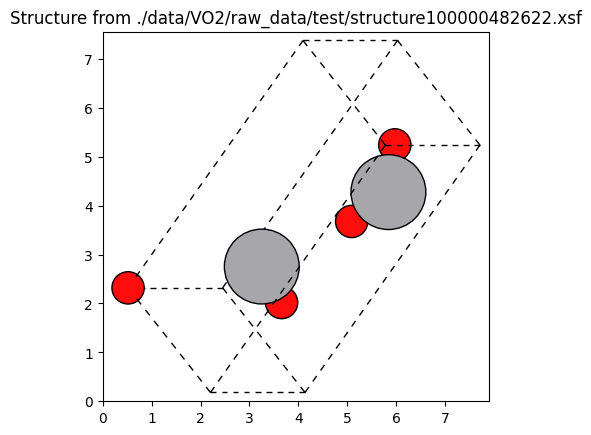

NGLWidget()

In [16]:
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview as nv
import random, os

random.seed(43)

# Randomly take a .xsf from the test dataset
file_to_read = './data/VO2/raw_data/test'
file_to_read = os.path.join(file_to_read, random.choice(os.listdir(file_to_read)))
print(f"Reading structure from: {file_to_read}")
ase_atom = ase.io.read(file_to_read)

fig, ax = plt.subplots()
plot_atoms(ase_atom, ax, radii=0.5, rotation=('45x,45y,0z'))
plt.title(f"Structure from {file_to_read}")
plt.show()


# Create an interactive view from the ase object
view = nv.show_ase(ase_atom)
view.add_unitcell()
view

Reading structure from: ./data/VO2/raw_data/test/structure100000151415.xsf


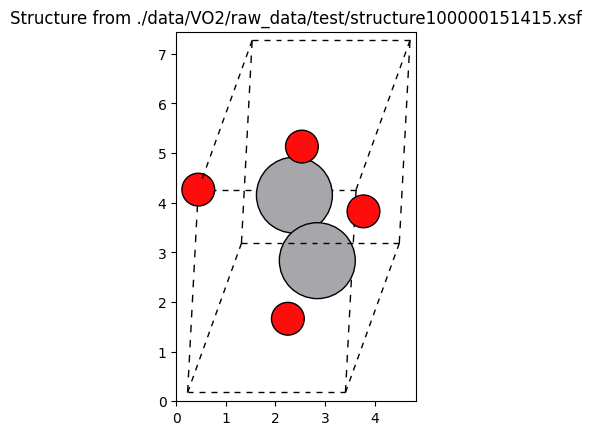

NGLWidget()

In [17]:
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview as nv
import random, os

random.seed(44)

# Randomly take a .xsf from the test dataset
file_to_read = './data/VO2/raw_data/test'
file_to_read = os.path.join(file_to_read, random.choice(os.listdir(file_to_read)))
print(f"Reading structure from: {file_to_read}")
ase_atom = ase.io.read(file_to_read)

fig, ax = plt.subplots()
plot_atoms(ase_atom, ax, radii=0.5, rotation=('45x,45y,0z'))
plt.title(f"Structure from {file_to_read}")
plt.show()


# Create an interactive view from the ase object
view = nv.show_ase(ase_atom)
view.add_unitcell()
view

Reading structure from: ./data/VO2/raw_data/test/structure10000027824.xsf


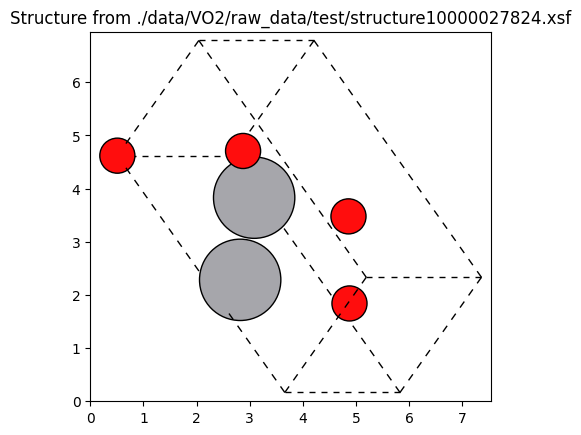

NGLWidget()

In [18]:
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview as nv
import random, os

random.seed(45)

# Randomly take a .xsf from the test dataset
file_to_read = './data/VO2/raw_data/test'
file_to_read = os.path.join(file_to_read, random.choice(os.listdir(file_to_read)))
print(f"Reading structure from: {file_to_read}")
ase_atom = ase.io.read(file_to_read)

fig, ax = plt.subplots()
plot_atoms(ase_atom, ax, radii=0.5, rotation=('45x,45y,0z'))
plt.title(f"Structure from {file_to_read}")
plt.show()


# Create an interactive view from the ase object
view = nv.show_ase(ase_atom)
view.add_unitcell()
view

# Data Loading

### Input to the neural network: Chebyshev Polynomials

**Chebyshev polynomials** are special **orthogonal polynomials** used in approximation theory and numerical methods.

#### Two Main Types

- **First Kind** ($T_n(x)$):
  - Recurrence:
    - $T_0(x) = 1$
    - $T_1(x) = x$
    - $T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$
  - Alternative definition:
    - $T_n(x) = \cos(n \arccos(x))$

- **Second Kind** ($U_n(x)$):
  - Recurrence:
    - $U_0(x) = 1$
    - $U_1(x) = 2x$
    - $U_{n+1}(x) = 2xU_n(x) - U_{n-1}(x)$
  - Alternative definition:
    - $U_n(x) = \dfrac{\sin((n+1)\theta)}{\sin(\theta)}$ where $x = \cos(\theta)$

#### Key Properties

- **Orthogonality**:
  - $T_n(x)$ is orthogonal on $[-1, 1]$ with weight $1/\sqrt{1 - x^2}$
  - $U_n(x)$ is orthogonal on $[-1, 1]$ with weight $\sqrt{1 - x^2}$

- **Roots (Chebyshev Nodes)**:
  - Roots of $T_n(x)$ minimize interpolation error and reduce Runge's phenomenon.

- **Minimax Property**:
  - $T_n(x)$ minimizes the maximum deviation from zero on $[-1, 1]$ among monic polynomials.

- **Application in ML**:
  - Used to describe atomic environments as inputs for neural networks in materials science.


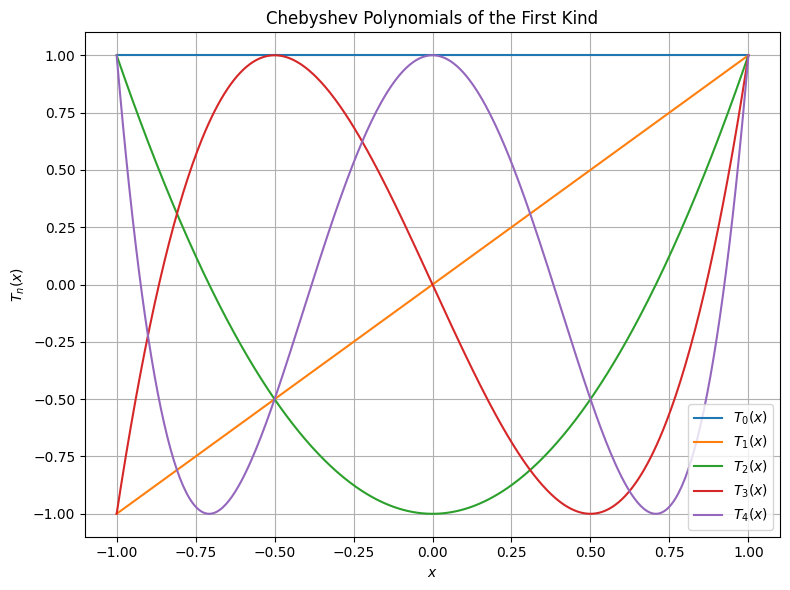

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev

# Generate x values in [-1, 1]
x = np.linspace(-1, 1, 400)

# Plot first 5 Chebyshev polynomials of the first kind (T0 to T4)
plt.figure(figsize=(8, 6))
for n in range(5):
    y = chebyshev.Chebyshev.basis(n)(x)
    plt.plot(x, y, label=f'$T_{n}(x)$')

plt.title('Chebyshev Polynomials of the First Kind')
plt.xlabel('$x$')
plt.ylabel('$T_n(x)$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
def train_prepare():
    with open( './train/generate.in', 'r') as f_read:
        for i, line in enumerate(f_read):
            if i == 3:
                num_type = int(line.split()[0]) 
    if num_type == 1:
        nfeatures = 22
    else:
        nfeatures = 44
    return nfeatures,num_type

nfeatures, num_type = train_prepare()

In [9]:
from get_dataset import get_dataset

# Load the dataset for training
data = get_dataset('./train', '/train/trainset_with_scaled_normalized.txt', nfeatures)

print(f"Number of features: {nfeatures}, Type: {num_type}")
print("Data loaded successfully.")

Number of features: 44, Type: 2
Data loaded successfully.


## Distribution of data

<p align="center">
  <img src="./img/distribution.png" alt="Neural network" width="1000"/>
</p>

Plotting Sample 0, Shape of feature values: (44, 30)


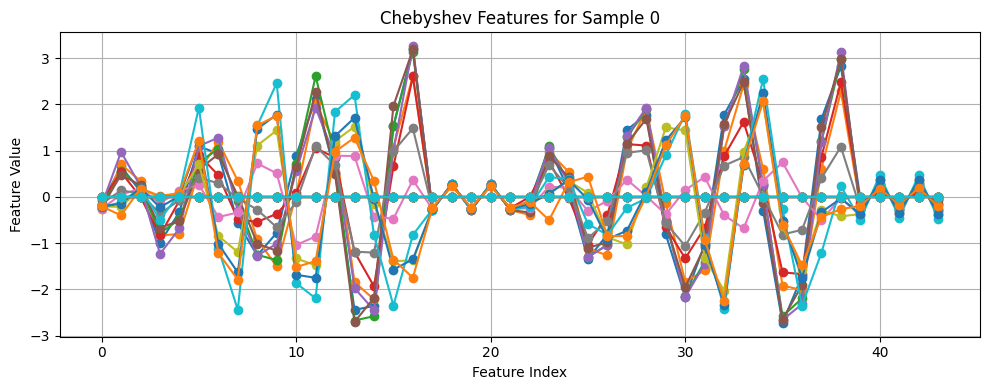

Plotting Sample 1, Shape of feature values: (44, 30)


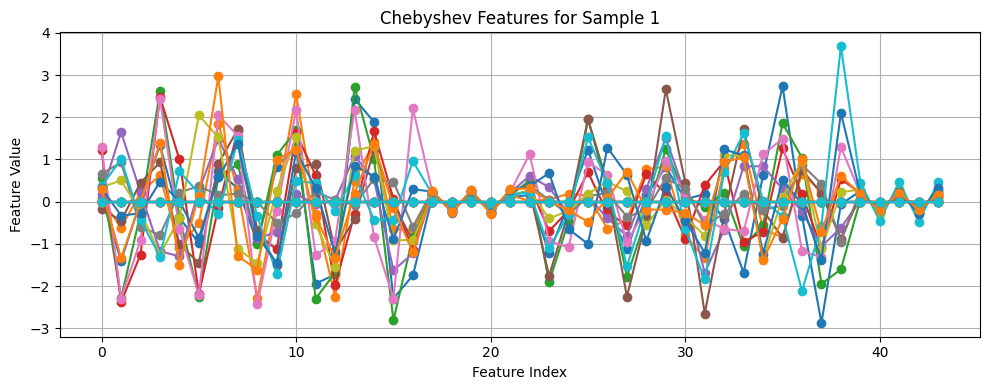

Plotting Sample 2, Shape of feature values: (44, 30)


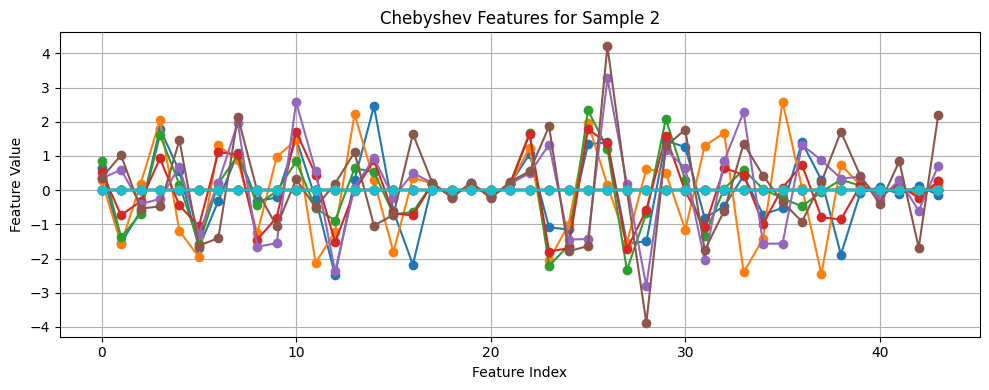

In [10]:
samples_to_plot = 3

for i in range(samples_to_plot):
  if i < len(data):
    coeff_list = data[i][0]

    coeff_values = np.array(coeff_list, dtype=float)
    coeff_values = coeff_values.reshape(-1, nfeatures).T
    
    print(f"Plotting Sample {i}, Shape of feature values: {coeff_values.shape}")

    plt.figure(figsize=(10, 4))
    plt.plot(coeff_values, marker='o', linestyle='-')
    plt.title(f"Chebyshev Features for Sample {i}")
    plt.xlabel("Feature Index")
    plt.ylabel("Feature Value")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
  else:
    print(f"Sample index {i} is out of bounds for the loaded data (size: {len(data)}).")
    break

# Neural Network

The neural network is used to **predict the energy of crystal structures**. The goal is to build a model that can learn the relationship between a material's atomic structure and its energy. This approach aims to speed up the discovery and design of new materials.

### Core Purpose
* The network is designed to fit the atomic energy of crystal structures, working on the principle that structures will favor lower energy states.
* It calculates the energy for each atom in a crystal; these individual atomic energies are then summed up in the output layer to determine the total energy of the entire structure.

### Neural Network Architecture
* The network consists of four layers:
    * One **input layer** (which takes the Chebyshev polynomial descriptors).
    * Two **hidden layers**.
    * One **output layer** (which outputs the fitted atomic energy).
* Each of the two hidden layers is composed of 10 neurons.

<p align="center">
  <img src="./img/neural_network.png" alt="Neural network" width="800"/>
</p>

In [11]:
file_scale = './temp_files/scale.txt'
scale = 0
    
class NeuralNetwork(nn.Module):
    def __init__(self, nfeat, w_b = None):
        super().__init__()
        self.nfeat = nfeat
        self.types = self._load_types('./train/generate.in')
        architecture = nn.Sequential(
                    nn.Linear(self.nfeat, 10),
                    nn.Tanh(),
                    nn.Linear(10, 10),
                    nn.Tanh(),
                    nn.Linear(10, 1)
                )
        for t in self.types:
            setattr(self, f"{t}_forward", architecture)

        if w_b is not None:
            self._assign_weights(w_b)

    def _load_types(self, filepath):
        with open(filepath, 'r') as f:
            lines = f.readlines()
        num_type = int(lines[3].split()[0])
        return [lines[i].split()[0] for i in range(4, 4 + num_type)]

    def _assign_weights(self, w_b):
        for idx, module in enumerate(
            filter(lambda m: isinstance(m, nn.Linear), self.modules()), start=1
        ):
            w_key, b_key = f"w_{idx}", f"b_{idx}"
            if w_key in w_b and b_key in w_b:
                module.weight = nn.Parameter(w_b[w_key])
                module.bias = nn.Parameter(w_b[b_key])

    def forward(self, x, flag_list):
        outputs = []
        tmp_all = []

        for sample_idx in range(x.size(0)):
            tmp = []
            for feature_idx, flag in enumerate(flag_list):
                forward_name = f"{flag[sample_idx]}_forward"
                if hasattr(self, forward_name):
                    forward_func = getattr(self, forward_name)
                    tmp.append(forward_func(x[sample_idx][feature_idx]))
            tmp_all.append(len(tmp))
            outputs.append(torch.stack(tmp, 0).sum())

        out_tensor = torch.stack(outputs, 0).view(x.size(0), 1)
        return out_tensor, tmp_all


## Initialization parameters of the neural network

Here we initialize the parameters of the neural network such that they are compatible with our architecture. These parameters will be optimized during the training process.

In [13]:
def _extract_and_shape_single_network_params(popunum_block, nfeatures, key_idx_prefix):
    params = {}
    current_idx = 0

    layer_configs = [
        (10, nfeatures),  # Layer 1: nfeatures -> 10
        (10, 10),         # Layer 2: 10 -> 10
        (1, 10),          # Layer 3: 10 -> 1
    ]

    for i, (out_dim, in_dim) in enumerate(layer_configs):
        # Weights
        w_len = out_dim * in_dim
        params[f'w_{key_idx_prefix + i}'] = torch.Tensor(
            popunum_block[current_idx : current_idx + w_len]
        ).view(out_dim, in_dim)
        current_idx += w_len

        # Biases
        b_len = out_dim  # Bias has 'out_dim' elements
        params[f'b_{key_idx_prefix + i}'] = torch.Tensor(
            popunum_block[current_idx : current_idx + b_len]
        )
        current_idx += b_len
    
    return params

def init_w_b(popunum, num_type, nfeatures):
    
    all_network_params = {}
    current_popunum_offset = 0

    elements_per_network_block = (10 * nfeatures) + 10 + (10 * 10) + 10 + (1 * 10) + 1

    for i in range(num_type):
        key_idx_prefix_for_current_block = (3 * i) + 1
        
        start_idx = current_popunum_offset
        end_idx = current_popunum_offset + elements_per_network_block
        popunum_block = popunum[start_idx:end_idx]
        
        block_params = _extract_and_shape_single_network_params(
            popunum_block, nfeatures, key_idx_prefix_for_current_block
        )
        all_network_params.update(block_params)
        
        current_popunum_offset = end_idx
        
    return all_network_params

# Loss Function: RMSE

The loss is computed using the formula:

$$
\text{loss} = \frac{1}{s} \sqrt{ \frac{1}{M} \sum_{i=1}^{M} \frac{1}{2} \left( \frac{x_i - y_i}{N} \right)^2 }
$$

where M is the total number of elements in the batch, N is the number of atoms in the crystal structure, and s is a scaling factor.

In [14]:
class RMSE(nn.Module):
  def __init__(self):
    super(RMSE, self).__init__()
  def forward(self, inputs, targets, natoms):
    global scale
    if scale == 0 and os.path.exists(file_scale):
        with open(file_scale, 'r') as f:
            for line in f:
                scale = float(line.strip().split()[0])
    loss = torch.pow((inputs - targets) / torch.tensor(natoms), 2) * 0.5
    loss = loss.mean().sqrt() / scale
    return loss

## Early Stopping
Early stopping is a technique used to prevent overfitting during training. It monitors the validation loss and stops training when the loss does not improve for a specified number of epochs (patience). This helps in finding the optimal model without unnecessary training.

In [15]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        self.val_loss_min = val_loss

## Training process

The training process involves the following steps:
1. **Data Preparation**: Load the crystal structures and their corresponding energies, shuffle the data and splitting it into batches.
2. **Model Initialization**: Create the neural network model with the specified architecture.
3. **Training Loop**:
   - For each epoch:
     - For each batch:
       - Forward pass: Compute the predicted energies using the neural network.
       - Compute the loss using the RMSE function.
       - Backward pass: Update the model parameters using the optimizer.
        - Check for early stopping conditions.
4. **Validation**: After each epoch, evaluate the model on the validation set to monitor performance.

All this is done in parallel using Ray to speed up the training process among multiple CPU cores (and many neural networks). Moreover the optimization process is done using the PGB algorithm (explained later).

In [16]:
from get_dataset import TrainDataset

def train_process(nfeat, popunum, f_main, thread_index):
    setup_seed(100)
    
    with open('./train/generate.in', 'r') as f_read:
        for i, line in enumerate(f_read):
            if i == 3:
                num_type = int(line.split()[0])

    w_b = init_w_b(popunum, num_type, nfeat)
    
    train_data, vali_data = train_test_split(data, test_size=0.1, random_state=42)

    device = torch.device("cuda" if thread_index == 9999 and torch.cuda.is_available() else "cpu")
    
    train_dataset = TrainDataset(train_data, device)
    vali_dataset = TrainDataset(vali_data, device)
    train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
    vali_loader = DataLoader(vali_dataset, batch_size=1, shuffle=False)

    model = NeuralNetwork(nfeat, w_b).to(device)
    min_vali, history_train, history_val = train_model(model, train_loader, vali_loader, f_main, thread_index, device)
    
    return min_vali, history_train, history_val


def train_model(model, train_loader, vali_loader, f_main, thread_index, device):
    EPOCHS = 500 if thread_index == 9999 else 1
    min_vali = float('inf')

    criterion = RMSE()
    optimizer = optim.Adamax(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0)
    early_stopping = EarlyStopping(patience=40, verbose=True)

    history_train_loss = []
    history_vali_loss = []

    for epoch in range(EPOCHS):
        st = time.time()
        loss_train, loss_vali, real_loss = {}, {}, {}

        # === Training ===
        model.train()
        for i, (x, flag_list, y, struct_name) in enumerate(train_loader, start=1):
            x = x
            y = y
            flag_list = flag_list

            out, num_nopad = model(x, flag_list)
            loss = criterion(out, y, num_nopad)

            loss_train[struct_name] = loss.item()

            optimizer.zero_grad()
            if loss.item() != 0.0:
                loss.backward()
            optimizer.step()

        train_loss = sum(loss_train.values()) / len(loss_train)
        history_train_loss.append(train_loss)

        # === Validation ===
        model.eval()
        with torch.no_grad():
            for i, (x, flag_list, y, struct_name) in enumerate(vali_loader, start=1):
                x = x
                y = y
                flag_list = flag_list

                out, num_nopad = model(x, flag_list)
                loss = criterion(out, y, num_nopad)
                loss_vali[struct_name] = loss.item()

                real_diff = (out.data[0] - y.data[0]) / scale
                real_loss[struct_name] = abs(real_diff)

        avg_real_loss = sum(real_loss.values()).numpy()[0] / len(real_loss)
        max_real_loss = max(real_loss.values()).numpy()[0]
        vali_loss = sum(loss_vali.values()) / len(loss_vali)
        history_vali_loss.append(vali_loss)

        print(f"[{epoch:03d}/{EPOCHS}], time: {time.time() - st:.3f}s, "
              f"train_loss: {train_loss:.6f}, vali_loss: {vali_loss:.6f}, "
              f"avg_real_loss: {avg_real_loss:.6f}, max_real_loss: {max_real_loss:.6f}")

        early_stopping(vali_loss)
        model_dir = os.path.join(WORKPLACE, 'model', 'model_' + str(thread_index) + '/model.pkl')
        print(f"Model directory: {model_dir}")

        if vali_loss < min_vali:
            min_vali = vali_loss
            if thread_index == 9999:
                print(f"Saving model to {model_dir}")
                torch.save(model.state_dict(), model_dir)

        if early_stopping.early_stop:
            break

    return min_vali, history_train_loss, history_vali_loss

## Fitness Evaluation
The fitness evaluation is a crucial step in the genetic algorithm where each individual in the population is assessed based on how well it performs the task at hand. In our case, the task is to train a neural network to predict the energy of crystal structures.

In [17]:
@ray.remote
def fitnessFunction(population_vector, thread_index):
    log_path = f'output_all/log{thread_index}.txt'
    with open(log_path, 'a+') as log_file:

        temp_file = os.path.join(WORKPLACE, 'train', 'file.temp')
        if os.path.exists(temp_file):
            os.remove(temp_file)

        os.system(f'cp {WORKPLACE}/train/generate.in ./temp_files/')

        model_path = os.path.join(WORKPLACE, 'train', 'model.pkl')
        if os.path.exists(model_path):
            os.remove(model_path)

        n_features = 44
        min_val, history_train, history_val = train_process(n_features, population_vector, log_file, thread_index)

    return -min_val, history_train, history_val

# Calculates the fitness value of a population of chromosomes by evaluating each 
# chromosome's performance.
def getFitnessValue(decode, thread_index=0):

    history_train = []
    history_val = []
    
    if thread_index == 9999:
        fitness_value, history_train, history_val = ray.get(fitnessFunction.remote(decode, thread_index))
        fitness_values = np.array([fitness_value])
    else:
        pop_size, _ = decode.shape
        results = [fitnessFunction.remote(decode[i], i) for i in range(pop_size)]
        fitness_values = np.array([res[0] for res in ray.get(results)])

    print(f"Fitness values: {fitness_values}")

    total_fitness = np.sum(fitness_values)
    probability = fitness_values / total_fitness if total_fitness != 0 else np.ones_like(fitness_values) / len(fitness_values)
    cum_probability = np.cumsum(probability)

    return fitness_values, cum_probability, history_train, history_val

# PGB (Particle swarm Genetic Bayesian) Algorithm
The PGB algorithm is a hybrid method that mixes Genetic Algorithm (GA), Particle Swarm Optimization (PSO), and Bayesian Optimization to fine-tune neural network parameters, especially for materials science. The main goal is to boost model's accuracy (at the cost of some computational resources).

## How PGB Works

1.  **Start**: It begins by setting up the neural network and creating an initial "population" of possible parameter sets.
2.  **Check Fitness**: Each parameter set is tested by training a neural network and seeing how well it performs.
3.  **Bayes optimization**: If the algorithm isn't finding better solutions after a while, Bayesian optimization steps in to suggest new, diverse parameter sets to try.
4.  **Evolve**: The algorithm then uses GA techniques:
    * **Selection**: Good-performing parameter sets are chosen.
    * **Crossover**: These sets are combined, notably by mixing them with the current best-performing set.
    * **Mutation**: Parameters are slightly changed using a mix of PSO-like adjustments and standard random changes. The balance between these mutation types adapts as the search progresses.
5.  **Repeat**: These steps are repeated until a stopping condition is met. The best parameters found are then used for the final neural network training.

## Why PGB?

By blending these techniques, PGB aims to:
* Explore a wide range of possible solutions (thanks to GA).
* Quickly find promising areas (thanks to PSO).
* Avoid getting stuck on solutions that aren't truly the best (thanks to Bayesian Optimization).

The overall aim is to get more stable, efficient, and precise neural network models for tasks like predicting material energies.


<p align="center">
  <img src="./img/full_algorithm.png" alt="Alt text" width="800"/>
</p>

# Genetic Algorithm (GA) Overview

The genetic algorithm (GA) is an optimization method inspired by the process of biological evolution, specifically the concept of "natural selection, survival of the fittest".

1.  **Initialization**: The process begins by creating an initial population of individuals. Each individual represents a potential solution and is typically encoded in some form (e.g., as a string of parameters).
2.  **Fitness Evaluation**: Each individual in the population is evaluated based on a "fitness value". This value quantifies how good the solution represented by the individual is. For instance, the root mean square error (RMSE) can be used as a fitness value, where a lower RMSE indicates a better fitness.
3.  **Selection**: Individuals are selected from the current population to create a basis for the next generation. This selection is typically based on their fitness values, with fitter individuals having a higher chance of being chosen.
4.  **Genetic Operators**:
    * **Crossover**: New individuals (offspring) are generated by combining genetic material from selected parent individuals. This involves exchanging parts of their encoded representations (chromosomes). In a specific application mentioned, each individual might be crossed with the current global best individual in the population.
    * **Mutation**: Random alterations are introduced into the new individuals at a certain probability. This helps maintain diversity in the population and explore new areas of the solution space. One form of mutation is real number mutation, where a gene of an individual is randomly changed within a defined range.
5.  **New Generation and Iteration**: The new individuals generated through crossover and mutation form the next generation of the population. This entire process (fitness evaluation, selection, crossover, and mutation) is repeated for a number of generations or until certain convergence conditions are met, such as reaching a maximum number of iterations or when the improvement in fitness stagnates.

The goal is that over generations, the population will evolve towards better solutions to the problem being optimized.

<p align="center">
  <img src="./img/genetic_flowchart.jpg" alt="Alt text" width="300"/>
</p>

## Initialization

The initialization of the genetic algorithm involves setting up the initial population of individuals, each representing a potential solution to the optimization problem. The parameters for each individual are randomly generated within specified ranges.

In [15]:
from scipy.optimize import fsolve

# Generates an initial binary population (chromosomes) for a genetic algorithm.
def getinitialPopulation(length, populationSize):
  chromsomes = np.zeros((populationSize, length), dtype=int)
  for popusize in range(populationSize):
      chromsomes[popusize, :] = np.random.randint(0, 2, length)
  return chromsomes

## Encoding and Decoding

In the context of the genetic algorithm, encoding refers to how the parameters of each individual are represented. In this case, each individual is encoded as a list of binary numbers, where each number corresponds to a specific parameter of the neural network. On the other hand, decoding is the process of converting these encoded parameters back into a format that can be used by the neural network. This typically involves mapping the binary numbers to the actual weights and biases of the neural network.

In [16]:
# Calculates the number of bits needed to encode each decision variable based on its range 
# and a desired precision (delta).
def getEncodeLength(decisionvariables, delta):
  lengths = []
  for decisionvar in decisionvariables:
      uper = decisionvar[1]
      low = decisionvar[0]
      res = fsolve(lambda x: ((uper - low) / delta - 2 ** x + 1), 30)
      length = int(np.ceil(res[0]))
      lengths.append(length)
  return lengths

# Converts a binary chromosome to a binary representation of real values based on the encoding length and decision range.
def getEncodeBinary(real_values, encode_length, decision_range):
  lower, upper = decision_range[0]
  num_bits = encode_length[0]

  # Scale and quantize
  normalized = ((real_values - lower) / (upper - lower)) * (2 ** num_bits - 1)
  quantized = np.round(normalized).astype(int)

  # Convert to binary strings and pad
  def to_binary(x):
    return list(map(int, format(x, f'0{num_bits}b')))

  binary_encoded = np.array([to_binary(val) for val in quantized.flatten()])
  binary_encoded = binary_encoded.reshape(real_values.shape[0], -1)

  return binary_encoded

# Converts a binary population (chromosomes) back to real values based on the encoding length and decision range.
def getDecode(binary_population, encode_length, decision_range):
  lower, upper = decision_range[0]
  num_bits = encode_length[0]
  n_samples = binary_population.shape[0]
  n_vars = binary_population.shape[1] // num_bits

  # Reshape and interpret as binary integers
  reshaped = binary_population.reshape(n_samples, n_vars, num_bits)
  powers = 2 ** np.arange(num_bits - 1, -1, -1)
  integer_values = np.sum(reshaped * powers, axis=2)

  # Scale back to real values
  real_values = lower + integer_values * (upper - lower) / (2 ** num_bits - 1)
  return real_values

## Selection population
The selection process in a genetic algorithm is designed to choose individuals from the current population to create the next generation. The goal is to favor individuals with higher fitness values, ensuring that better solutions have a higher chance of being passed on.


<p align="center">
  <img src="./img/selection.png" alt="Selection" width="700"/>
</p>

In [17]:
def selectNewPopulation(decoded_population, cumulative_probabilities):
    num_individuals, _ = decoded_population.shape
    new_population = np.zeros_like(decoded_population)

    for i in range(num_individuals):
        r = np.random.rand()
        for j in range(num_individuals):
            if r < cumulative_probabilities[j]:
                new_population[i] = decoded_population[j]
                break

    return new_population


def evaluate_population(binary_population, encoding_lengths, variable_bounds):
    decoded_population = getDecode(binary_population, encoding_lengths, variable_bounds)
    fitness_values, cumulative_probabilities, _, _ = getFitnessValue(decoded_population)
    return decoded_population, fitness_values, cumulative_probabilities


## Crossover
Crossover is a genetic operator used to combine the genetic information of two parent individuals to create one or more offspring. This process mimics biological reproduction and is essential for introducing diversity into the population.

<p align="center">
  <img src="./img/crossover.png" alt="Selection" width="1000"/>
</p>

In [18]:
# performs crossover on a population based on the best individual.
def crossover_population(population, crossover_prob, fitness_scores):
    num_individuals, num_genes = population.shape
    best_idx = np.argmax(fitness_scores)
    num_to_cross = int(np.round(num_individuals * crossover_prob))

    # Ensure an even number for pairing
    if num_to_cross % 2 != 0:
        num_to_cross += 1

    # Prepare new population
    new_population = np.copy(population)

    # Select individuals for crossover
    selected_indices = random.sample(range(num_individuals), num_to_cross)
    
    for idx in selected_indices:
        crossover_point = np.random.randint(1, num_genes)  # avoid 0 to prevent no crossover
        if np.random.rand() < 0.5:
            new_population[idx, crossover_point:] = population[best_idx, crossover_point:]
        else:
            new_population[idx, :crossover_point] = population[best_idx, :crossover_point]

    return new_population

# Selects the top individuals from a population based on their fitness scores.
def select_top_individuals(population, fitness_scores, num_selected, top_k):
    flat_scores = fitness_scores.flatten()
    top_indices = heapq.nlargest(top_k, range(len(flat_scores)), key=flat_scores.__getitem__)
    
    top_population = np.zeros((num_selected, population.shape[1]))
    top_fitness = np.zeros(num_selected)

    for i, idx in enumerate(top_indices[:num_selected]):
        top_population[i] = population[idx]
        top_fitness[i] = fitness_scores[idx]

    return top_population, top_fitness

## Mutation
Mutation is a genetic operator used in genetic algorithms to introduce random changes to individuals in the population. This process helps maintain genetic diversity and allows the algorithm to explore new areas of the solution space. In 

* Randomly alters genes in individuals.
* Helps explore **new areas** of the search space.
* Reduces risk of **premature convergence**.

<p align="center">
  <img src="./img/mutation.png" alt="Selection" width="1000"/>
</p>

### PSO (Particle Swarm Optimization)
PSO improves individuals by learning from their own best past performance, called the personal best, and from the best solution found by the entire population, called the global best. It balances exploration, which is trying new solutions, and exploitation, which is refining good ones. PSO uses a velocity-based update to guide the movement of individuals through the solution space.

<p align="center">
  <img src="./img/particle_swarm.png" alt="Selection" width="400"/>
</p>



In [19]:
def apply_mutation_and_pso(population, fitness_values, pso_idx, mutation_idx, mutation_prob):

    # --- PSO hyperparameters ---
    w_inertia = 0.5
    c_personal = 2.0
    c_social = 3.0
    value_bounds = (-1.0, 1.0)

    # Find global and personal bests
    global_best = population[np.argmax(fitness_values)].copy()
    personal_best = population[pso_idx].copy()

    # Apply mutation to the selected individual
    population[mutation_idx] = mutate_individual(population[mutation_idx], mutation_prob)

    # PSO-style update to the selected individual
    r1, r2 = np.random.rand(2)
    current = population[pso_idx]
    velocity_update = (
        w_inertia * current +
        c_personal * r1 * (personal_best - current) +
        c_social * r2 * (global_best - current)
    )
    # Clamp to bounds
    population[pso_idx] = np.clip(velocity_update, *value_bounds)

    return population

# Mutates an individual by randomly changing a certain number of genes based on the mutation probability.
def mutate_individual(individual, mutation_prob):
    mutated = np.copy(individual)
    num_genes = mutated.shape[-1]

    # Flatten if needed
    if mutated.ndim == 2:
        mutated = mutated.reshape(-1, num_genes)

    total_genes = mutated.size
    num_mutations = int(total_genes * mutation_prob)
    indices_to_mutate = random.sample(range(total_genes), num_mutations)

    for idx in indices_to_mutate:
        row = idx // num_genes
        col = idx % num_genes
        mutated[row, col] = np.random.uniform(-1.0, 1.0)

    return mutated

Function to perform crossover and mutation.

In [20]:
def crossover_and_mutate(population, crossover_probability, fitness, encoding_lengths, bounds, stagnation_counter, initial_pso_rate, mutation_base_prob):
    crossed_population = crossover_population(population, crossover_probability, fitness)
    decoded_crossed = getDecode(crossed_population, encoding_lengths, bounds)

    pso_rate = max(0, initial_pso_rate - 0.1 * stagnation_counter)
    mutation_prob = min(0.5, mutation_base_prob * stagnation_counter)

    population_size = decoded_crossed.shape[0]
    pso_indices = random.sample(range(population_size), int(population_size * pso_rate))
    other_indices = list(set(range(population_size)) - set(pso_indices))

    mutated_decoded = apply_mutation_and_pso(decoded_crossed, fitness, pso_indices, other_indices, mutation_prob)
    mutated_population = getEncodeBinary(mutated_decoded, encoding_lengths, bounds)

    return mutated_population, mutated_decoded

## Bayesian Optimization

Bayesian Optimization is a strategy for global optimization of expensive-to-evaluate functions. It builds a probabilistic model (e.g., Random Forest, Gaussian Process) of the objective function and uses it to select the most promising points to evaluate next, balancing exploration and exploitation. 
In our case we use the random forest in a search space of `[-1.0, 1.0]` for each parameter with the Expected Improvement (EI) acquisition function.

**Expected Improvement (EI)** quantifies how much improvement over the current best solution is expected by sampling a candidate point. It guides the optimizer to choose points that either have high predicted performance or high uncertainty, effectively balancing exploration of unknown areas and exploitation of known good areas.

The optimizer:
1. Receives past samples (`tell`) with their fitness.
2. Suggests new candidates (`ask`) to improve the current solution.

In [21]:
def get_num_para_from_input(file_path='./train/generate.in', target_line=3):
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i == target_line:
                num_type = int(line.split()[0])
                break
    return {1: 351, 2: 1142, 3: 1713}.get(num_type, None)

num_para = get_num_para_from_input()

# Initialize the Bayesian optimizer
opt_bayes = skopt.Optimizer(
    [skopt.space.Real(-1.0, 1.0, name=f'x{i}') for i in range(num_para)],
    n_initial_points=0,
    base_estimator='RF',
    acq_func='EI',
    acq_optimizer='auto',
    random_state=0,
    n_jobs=10,
)

def bayesian_optimization_step(
    combined_population, combined_decoded, combined_fitness,
    encoding_lengths, bounds, resolution,
    bayes_pool_decoded, bayes_pool_fitness,
    n_replace=10
):
    # Inform the Bayesian optimizer about the current sampled points and their (negated) fitness
    opt_bayes.tell(bayes_pool_decoded.tolist(), (-1 * bayes_pool_fitness).tolist())

    # Request new candidate points from the Bayesian optimizer
    new_candidates = np.array(opt_bayes.ask(n_replace))

    # Evaluate the fitness of the new candidates
    new_fitness_values, _, _, _ = getFitnessValue(new_candidates)

    # Encode the new candidates into the binary representation used by the population
    new_encoded_candidates = getEncodeBinary(new_candidates, encoding_lengths, bounds)

    # Find indices of the worst performing individuals to replace
    flat_values = combined_fitness.flatten().tolist()
    worst_indices = list(map(flat_values.index, heapq.nlargest(n_replace, flat_values)))

    # Replace the worst individuals with the new candidates
    combined_population[worst_indices] = new_encoded_candidates
    combined_decoded[worst_indices] = new_candidates
    combined_fitness[worst_indices] = new_fitness_values

    return new_candidates, new_fitness_values

## Training without PGB
First, we train the neural network without the PGB algorithm to establish a baseline performance.

In [22]:
# Plot the training and validation loss history
def plot_loss_history(history_train, history_val):
  plt.figure(figsize=(12, 6))
  plt.plot(history_train, label='Training Loss', color='blue')
  plt.plot(history_val, label='Validation Loss', color='orange')
  plt.title('Training and Validation Loss History')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

(raylet) Warning: The remote function __main__.fitnessFunction is very large (35 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(fitnessFunction pid=7274) /var/folders/tb/hddnh_pd115f4lqqcsjvkv740000gn/T/ipykernel_87195/3075854479.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:212.)


(fitnessFunction pid=7274) [000/500], time: 1.594s, train_loss: 4.408076, vali_loss: 2.296739, avg_real_loss: 24.494678, max_real_loss: 85.881172
(fitnessFunction pid=7274) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=7274) Saving model to /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=7274) [001/500], time: 1.641s, train_loss: 1.988604, vali_loss: 1.253386, avg_real_loss: 13.763113, max_real_loss: 52.660660
(fitnessFunction pid=7274) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=7274) Saving model to /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=7274) [002/500], time: 1.530s, train_loss: 1.324399, vali_loss: 0.952554, avg_real_loss: 10.434587, max_real_loss: 41.720406
(fitnessFunction pid=7274) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/m

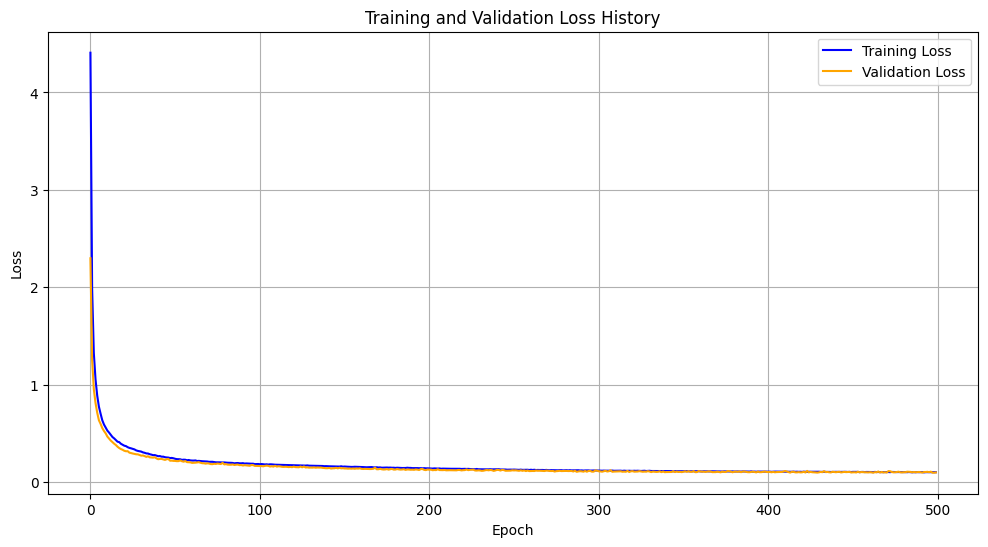

In [23]:
BOUNDS = [[-1.0, 1.0]] * num_para
RESOLUTION = 0.0001

# Initialize population and encoding
encoding_lengths = getEncodeLength(BOUNDS, RESOLUTION)
population = getinitialPopulation(sum(encoding_lengths), 1)
parameters = getDecode(population, encoding_lengths, BOUNDS)

min_vali, cum_proba, history_train, history_val = getFitnessValue(np.array(parameters[0]), 9999)
plot_loss_history(history_train, history_val)

print("Best fitness value:", min_vali)

# Evaluation on the test set

In [19]:
from get_dataset import PredictDataset

def predict_model(f_format, nfeat):
    
    model = NeuralNetwork(nfeat)
    model.load_state_dict(torch.load('./model/model_9999/model.pkl', map_location=torch.device('cpu')))
    model.eval()

    # Load prediction data
    data = np.load('./predict_data/predict.npy', allow_pickle=True)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare dataset and dataloader
    dataset = PredictDataset(data, device)
    dataloader = DataLoader(dataset, batch_size=1)

    # Load normalization parameters
    with open(file_scale, 'r') as f:
        scale = float(f.readline().strip().split()[0])
    with open(file_shift, 'r') as f:
        shift = float(f.readline().strip().split()[0])

    predictions_scaled = {}
    predictions_unscaled = {}
    structure_ids = []
    prediction_values = []

    # Run inference
    for x, flag_list, struct_name in dataloader:
        x_var = Variable(x)
        output, atom_count = model(x_var, flag_list)
        
        struct = struct_name[0]
        raw_prediction = output.data[0].item()

        structure_ids.append(struct)
        prediction_values.append(raw_prediction)

        predictions_scaled[struct] = raw_prediction
        predictions_unscaled[struct] = (raw_prediction / scale) + (float(atom_count[0]) * shift)

    # Save predictions to file
    output_path = os.path.join(os.path.abspath(os.path.dirname(f_format)), 'vasp_candidate.txt')
    with open(output_path, 'w') as f:
        for struct in structure_ids:
            f.write(f"{struct},{predictions_unscaled[struct]}\n")


## Metrics for Evaluation

In [25]:
from sklearn.metrics import r2_score
from sklearn import metrics


def result_conn():
    for model_index in range(1, 2):
        result_path = f'./predict/predict{model_index}/'
        ga_predict_file = os.path.join(result_path, 'GA_predict.txt')
        vasp_candidate_file = os.path.join(result_path, 'vasp_candidate.txt')
        result_con_file = os.path.join(result_path, 'result_con.txt')
        dft_result_file = './predict_data/result_DFT.txt'

        def generate_ga_predictions():
            if os.path.exists(ga_predict_file):
                os.remove(ga_predict_file)

            with open(vasp_candidate_file, 'r') as f_read, open(ga_predict_file, 'a') as f_write:
                for line in f_read:
                    parts = line.strip().split(',')
                    if len(parts) >= 2:
                        id_ga = parts[0][8:]
                        energy = parts[1]
                        f_write.write(f'{id_ga} {energy}\n')

        def combine_ga_dft_results():
            if os.path.exists(result_con_file):
                os.remove(result_con_file)

            # Read GA predictions into a dictionary for fast lookup
            ga_predictions = {}
            with open(ga_predict_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        ga_predictions[parts[0]] = parts[1]

            with open(dft_result_file, 'r') as f_dft, open(result_con_file, 'a') as f_out:
                for line in f_dft:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        id_ga, energy_ga = parts
                        energy_dft = ga_predictions.get(id_ga)
                        if energy_dft is not None:
                            f_out.write(f'{id_ga} {energy_ga} {energy_dft}\n')
                        else:
                            f_out.write(f'{id_ga} {energy_ga}\n')

        generate_ga_predictions()
        combine_ga_dft_results()


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) 

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) 

def RMSE_calu():

    R2_all = []
    MSE_all = []
    RMSE_all = []
    MAE_all = []
    MAPE_all = []

    for model_index in range(1,2):
        result_path = './predict/predict%s/'%model_index
        real = []
        predict = []
        with open(result_path + 'result_con.txt', 'r') as f_read:
            for i, line in enumerate(f_read):
                line = line.strip()
                standred = float(line.split()[1])
                GA_predict = float(line.split()[2])
                real.append(standred)
                predict.append(GA_predict)

        real = np.array(real)
        predict = np.array(predict)
        
        MSE_all.append(metrics.mean_squared_error(real, predict))
        RMSE_all.append(np.sqrt(metrics.mean_squared_error(real, predict)))
        MAE_all.append(metrics.mean_absolute_error(real, predict))
        MAPE_all.append(mape(real, predict))
        R2_all.append(r2_score(real,predict))

def result_conn2():
    for model_index in range(1, 2):
        result_path = f'./predict/predict{model_index}/'
        ga_predict_file = os.path.join(result_path, 'GA_predict.txt')
        ga_predict_num_file = os.path.join(result_path, 'GA_predict_atomenergy_num.txt')
        ga_atomenergy_file = os.path.join(result_path, 'GA_predict_atomenergy.txt')
        dft_numbers_file = './predict_data/numbers.txt'
        dft_atomenergy_file = './predict_data/result_DFT_atomenergy.txt'
        result_con_file = os.path.join(result_path, 'result_con.txt')

        def match_ga_with_atom_counts():
            # Load a mapping from ID → atom count
            id_to_atom_count = {}
            with open(dft_numbers_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        id_to_atom_count[parts[0]] = parts[1]

            # Write GA predictions + atom count to a file
            with open(ga_predict_file, 'r') as f_read, open(ga_predict_num_file, 'w') as f_write:
                for line in f_read:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        xsf_id, energy = parts
                        atom_count = id_to_atom_count.get(xsf_id)
                        if atom_count:
                            f_write.write(f'{xsf_id} {energy} {atom_count}\n')

        def compute_atom_energy():
            # Divide total energy by atom count
            with open(ga_predict_num_file, 'r') as f_read, open(ga_atomenergy_file, 'w') as f_write:
                for line in f_read:
                    parts = line.strip().split()
                    if len(parts) == 3:
                        xsf_id, total_energy, atom_count = parts
                        try:
                            atom_energy = float(total_energy) / float(atom_count)
                            f_write.write(f'{xsf_id} {atom_energy:.6f}\n')
                        except ZeroDivisionError:
                            continue

        def combine_ga_dft_atom_energy():
            if os.path.exists(result_con_file):
                os.remove(result_con_file)

            # Load GA atom energies into a dictionary
            ga_atom_energies = {}
            with open(ga_atomenergy_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) == 2:
                        ga_atom_energies[parts[0]] = parts[1]

            # Combine with DFT atom energies
            with open(dft_atomenergy_file, 'r') as f_read, open(result_con_file, 'w') as f_write:
                for line in f_read:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        xsf_id, dft_energy = parts
                        ga_energy = ga_atom_energies.get(xsf_id)
                        if ga_energy:
                            f_write.write(f'{xsf_id} {dft_energy} {ga_energy}\n')
                        else:
                            f_write.write(f'{xsf_id} {dft_energy}\n')

        # Run all steps
        match_ga_with_atom_counts()
        compute_atom_energy()
        combine_ga_dft_atom_energy()

def RMSE_calu2():

    R2_all = []
    MSE_all = []
    RMSE_all = []
    L1_all = []
    MAE_all = []
    MAPE_all = []


    for model_index in range(1,2):
        result_path = './predict/predict%s/'%model_index
        real = []
        predict = []
        with open(result_path + 'result_con.txt', 'r') as f_read:
            for i, line in enumerate(f_read):
                line = line.strip()
                standred = float(line.split()[1])
                GA_predict = float(line.split()[2])
                real.append(standred)
                predict.append(GA_predict)


        real = np.array(real)
        predict = np.array(predict)
        
        MSE_all.append(metrics.mean_squared_error(real, predict))
        RMSE_all.append(np.sqrt(metrics.mean_squared_error(real, predict)))
        L1_all.append(np.linalg.norm(real - predict, ord=1) / len(real))
        MAE_all.append(metrics.mean_absolute_error(real, predict))
        MAPE_all.append(mape(real, predict))
        R2_all.append(r2_score(real,predict))
        
    print('MSE',np.mean(MSE_all))
    print('RMSE',np.mean(RMSE_all))
    print('L1',np.mean(L1_all))
    print('MAE',np.mean(MAE_all))
    print('MAPE',np.mean(MAPE_all))
    print('R2',np.mean(R2_all))
    print()

def generate_plots(model_index=1):
    result_path = f'./predict/predict{model_index}/'
    real, predict = [], []
    
    try:
        with open(result_path + 'result_con.txt', 'r') as f_read:
            for line in f_read:
                parts = line.strip().split()
                real.append(float(parts[1]))
                predict.append(float(parts[2]))
    except FileNotFoundError:
        return

    real = np.array(real)
    predict = np.array(predict)

    plt.figure(figsize=(8, 8))
    plt.scatter(real, predict, alpha=0.6, edgecolors='k', s=50)
    
    lim_min = min(real.min(), predict.min())
    lim_max = max(real.max(), predict.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], 'r--', linewidth=2, label='Predizione Perfetta')
    
    plt.title('Correlation between real and predicted energy', fontsize=16)
    plt.xlabel('Real energy (per atom)', fontsize=12)
    plt.ylabel('Predicted energy (per atom)', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    
    errors = predict - real
    rmse = np.sqrt(np.mean(errors**2))
    l1 = np.linalg.norm(errors, ord=1) / len(errors)

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=40, edgecolor='black', alpha=0.7)
    
    plt.axvline(0, color='r', linestyle='--', linewidth=2, label='Null error')
    
    plt.title('Distribution of prediction errors', fontsize=16)
    plt.xlabel('Error (Predicted - Real)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.grid(axis='y', alpha=0.5)
    
    plt.text(0.95, 0.95, f'L1 = {l1:.4f}', transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()


MSE 0.07461188360867696
RMSE 0.27315175929998503
L1 0.1682789813
MAE 0.1682789813
MAPE 0.06987143775762221
R2 0.9740264261659003



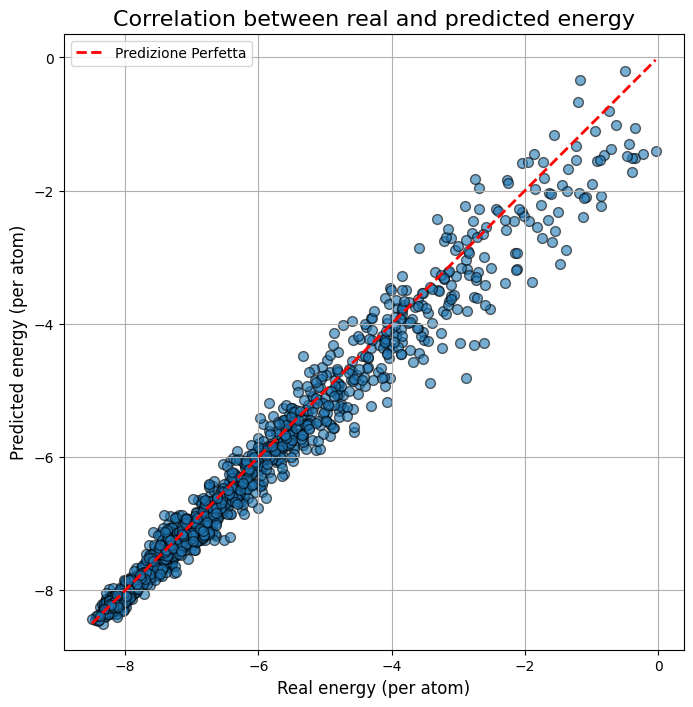

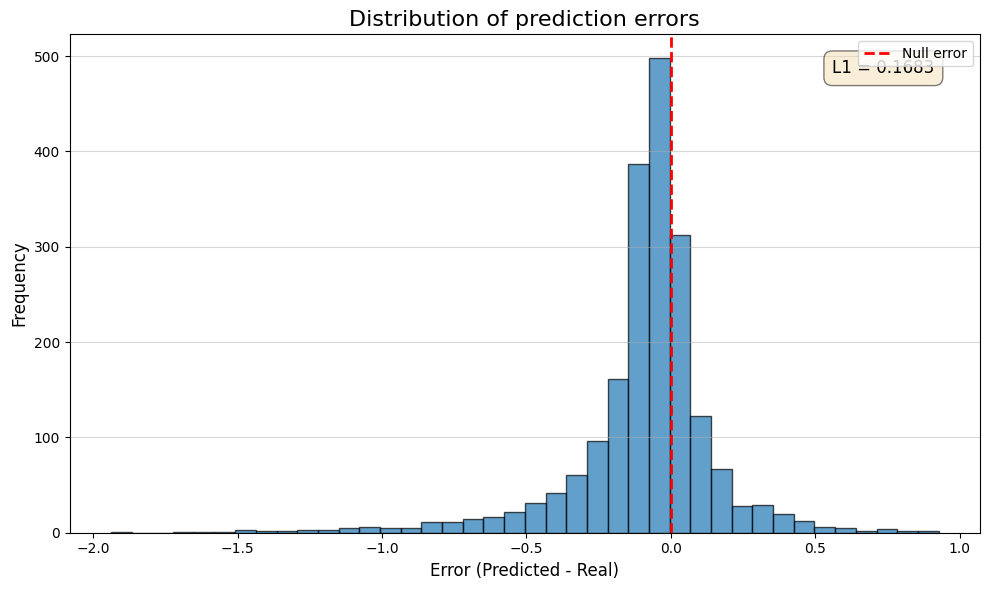

In [26]:
if os.path.exists('./predict/predict1'):
    shutil.rmtree('./predict/predict1')
    shutil.rmtree('./predict')
os.mkdir('./predict')
os.mkdir('./predict/predict1')
os.system('cp model/model_9999/model.pkl temp_files/')
os.system('cd temp_files; cp normal_para.txt normal_para_predict.txt')
os.system('cp temp_files/* ./predict/predict1')

predict_model('./predict/predict1/predictset_with_scaled_normalized.txt',nfeatures)

result_conn() 
RMSE_calu()

result_conn2() 
RMSE_calu2()

generate_plots()

## Paper comparison error

<p align="center">
  <img src="./img/BP_VO2.png" alt="Neural network" width="400"/>
</p>

Error RMSE: 0.32

Error L1: 0.20

Error MAPE: 0.07

Error R2: 0.96

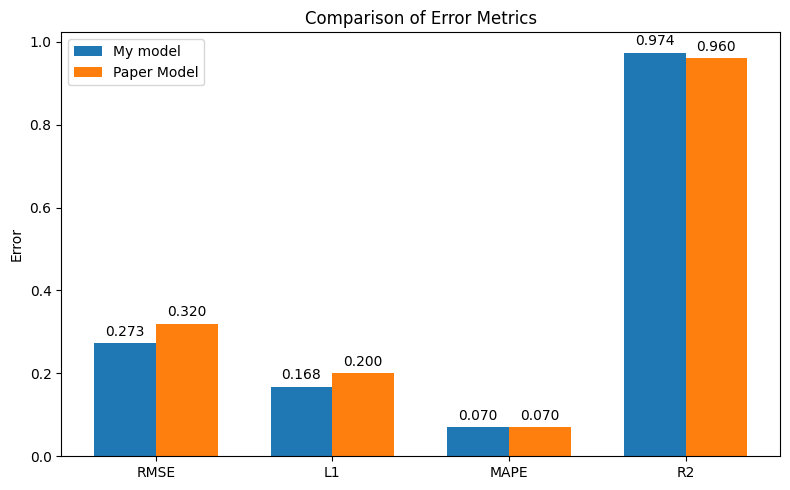

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'L1', 'MAPE', 'R2']

my_model = [0.27315175929998503, 0.1682789813, 0.06987143775762221, 0.9740264261659003]

# Paper model errors
paper_model = [0.32, 0.20, 0.07, 0.96]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8,5))

bars1 = ax.bar(x - width/2, my_model, width, label='My model')
bars2 = ax.bar(x + width/2, paper_model, width, label='Paper Model')

# Add text labels above bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

ax.set_ylabel('Error')
ax.set_title('Comparison of Error Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


# Optimization Algorithm: PGB

In [26]:
# Define parameters constants for the genetic algorithm
BOUNDS = [[-1.0, 1.0]] * num_para
RESOLUTION = 0.0001
POPULATION_SIZE = 20
MAX_GENERATIONS = 10
CROSSOVER_PROB = 0.8
MUTATION_BASE_PROB = 0.1
INITIAL_PSO_RATE = 0.8
STAGNATION_THRESHOLD = 3
BAYES_UPDATE_LIMIT = 5

In [27]:
from IPython.display import clear_output

# Function to plot fitness over generations
def plot_fitness(fitness_over_time, generation):
    clear_output(wait=True)
    plt.figure(figsize=(8, 4))
    plt.plot(fitness_over_time, label='Fitness')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.title(f'Generation {generation}')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

Here we define the PGB algorithm, which combines Genetic Algorithm (GA), Particle Swarm Optimization (PSO), and Bayesian Optimization to optimize the neural network parameters.

In [ ]:
def pgb():
    start_time = time.time()

    # Initialize population and encoding
    encoding_lengths = getEncodeLength(BOUNDS, RESOLUTION)
    population = getinitialPopulation(sum(encoding_lengths), POPULATION_SIZE)

    # Optimization state
    best_fitness = float('-inf')
    stagnation_counter = bayes_update_count = 0
    fitness_over_time, best_solutions, best_variables = [], [], []

    # Buffers for Bayesian optimization
    bayes_pool_decoded = np.empty((0, num_para))
    bayes_pool_fitness = np.array([])

    # Initial evaluation
    _, fitness_scores, _ = evaluate_population(
        population, encoding_lengths, BOUNDS
    )

    for generation in range(MAX_GENERATIONS):
        # Variation step: crossover and mutation
        mutated_population, decoded_mutated = crossover_and_mutate(
            population, CROSSOVER_PROB, fitness_scores,
            encoding_lengths, BOUNDS,
            stagnation_counter, INITIAL_PSO_RATE, MUTATION_BASE_PROB
        )

        # Evaluate mutated individuals
        decoded_original = getDecode(population, encoding_lengths, BOUNDS)
        mutated_fitness, _, _, _ = getFitnessValue(decoded_mutated)

        print(mutated_fitness)

        # Update Bayesian pool
        bayes_pool_decoded = np.vstack((bayes_pool_decoded, decoded_mutated))
        bayes_pool_fitness = np.hstack((bayes_pool_fitness, mutated_fitness))

        # Merge populations and fitness
        combined_population = np.vstack((population, mutated_population))
        combined_decoded = np.vstack((decoded_original, decoded_mutated))
        combined_fitness = np.hstack((fitness_scores, mutated_fitness))

        # Perform Bayesian update if stagnated
        if stagnation_counter >= STAGNATION_THRESHOLD:
            bayes_pool_decoded, bayes_pool_fitness = bayesian_optimization_step(
                combined_population, combined_decoded, combined_fitness,
                encoding_lengths, BOUNDS, RESOLUTION,
                bayes_pool_decoded, bayes_pool_fitness
            )
            bayes_update_count += 1

        # Select next generation
        population, fitness_scores = select_top_individuals(combined_population, combined_fitness, POPULATION_SIZE, POPULATION_SIZE)

        # Track best fitness
        current_best_fitness = np.max(combined_fitness)
        fitness_over_time.append(current_best_fitness)

        stagnation_counter += 1
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            stagnation_counter = 0

        # Store best solution
        best_index = np.argmax(combined_fitness)
        best_solutions.append(current_best_fitness)
        best_variables.append(combined_decoded[best_index].tolist())

        # Plot and log progress
        plot_fitness(fitness_over_time, generation)
        print(f'Generation {generation} time: {time.time() - start_time:.2f}s')

        print(fitness_over_time)
        
        if bayes_update_count >= BAYES_UPDATE_LIMIT:
            break

    # Return best overall result
    final_idx = np.argmax(best_solutions)
    return best_solutions[final_idx], best_variables[final_idx]


Here we run the PGB algorithm to optimize the neural network parameters, saving the best parameters found during the optimization process.

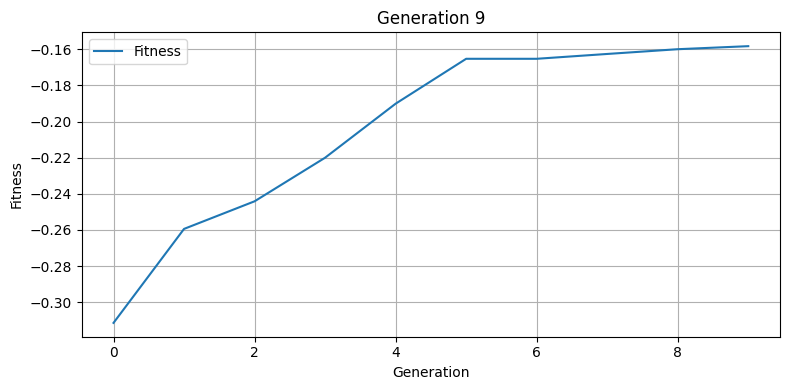

Generation 9 time: 346.58s
[-0.31138664979600433, -0.2593972184165614, -0.244129861027468, -0.22001686333009274, -0.19013512323916074, -0.16529914346465374, -0.1652985965512926, -0.16262567631201819, -0.1599967190892494, -0.15831659520379618]
Max fitness: -0.15831659520379618


In [29]:
optval, optvar = pgb()

print("Max fitness:", optval)

Here we train the final neural network for 500 epochs using the best parameters found by the PGB algorithm.

(fitnessFunction pid=44675) [000/500], time: 1.773s, train_loss: 0.886755, vali_loss: 0.158317, avg_real_loss: 1.748889, max_real_loss: 12.866728
(fitnessFunction pid=44675) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=44675) Saving model to /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=44675) [001/500], time: 1.543s, train_loss: 0.272478, vali_loss: 0.171059, avg_real_loss: 1.772663, max_real_loss: 13.373271
(fitnessFunction pid=44675) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=44675) [002/500], time: 1.636s, train_loss: 0.260749, vali_loss: 0.159253, avg_real_loss: 1.633917, max_real_loss: 11.468936
(fitnessFunction pid=44675) Model directory: /Users/matteobalice/Desktop/swarm_intelligence/model/model_9999/model.pkl
(fitnessFunction pid=44675) [003/500], time: 1.535s, train_loss: 0.251685, vali_loss: 0

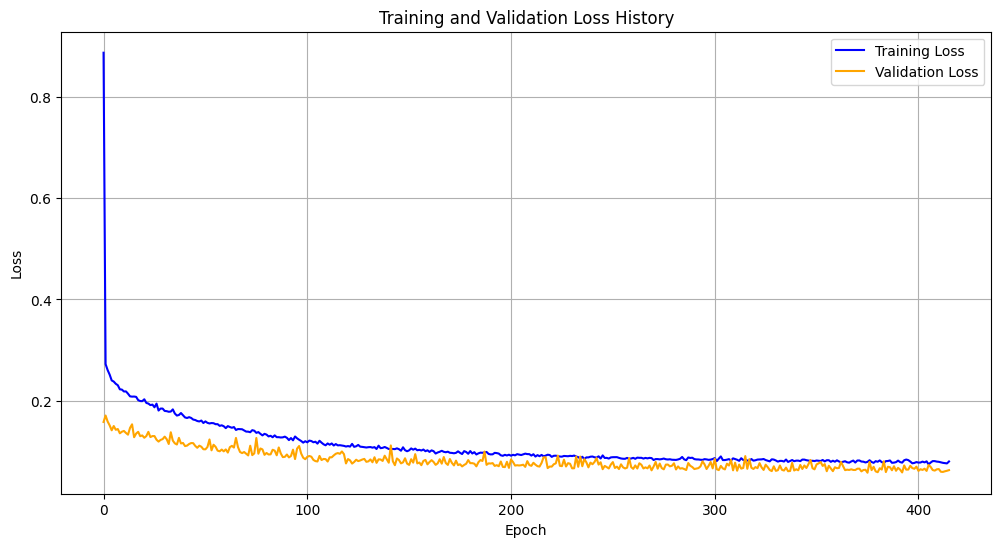

In [30]:
# Perform the final training and evaluation using the optimal parameters
min_vali, cum_proba, history_train, history_val = getFitnessValue(np.array(optvar), 9999)
plot_loss_history(history_train, history_val)

print("Best fitness value:", min_vali)

MSE 0.029047761825409957
RMSE 0.1704340395150275
L1 0.10749929869999997
MAE 0.10749929869999997
MAPE 0.034664627322155445
R2 0.9898880158227249



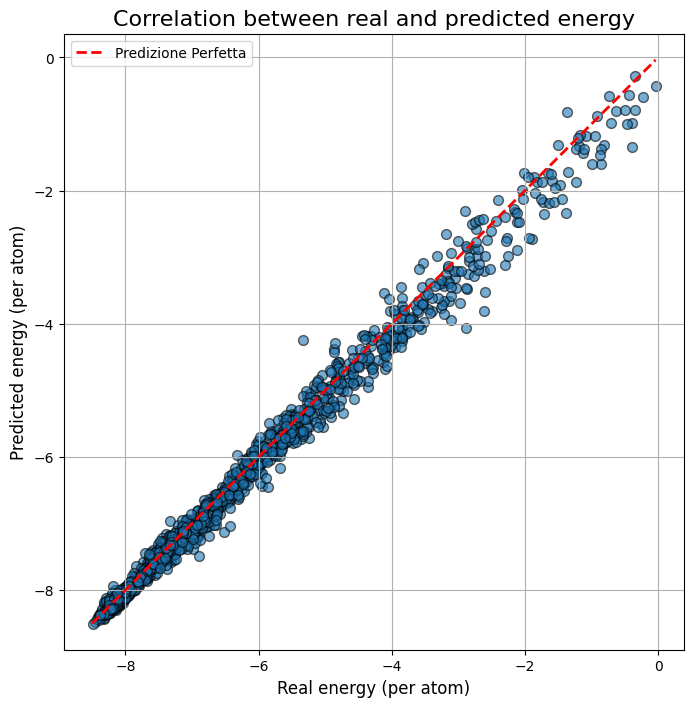

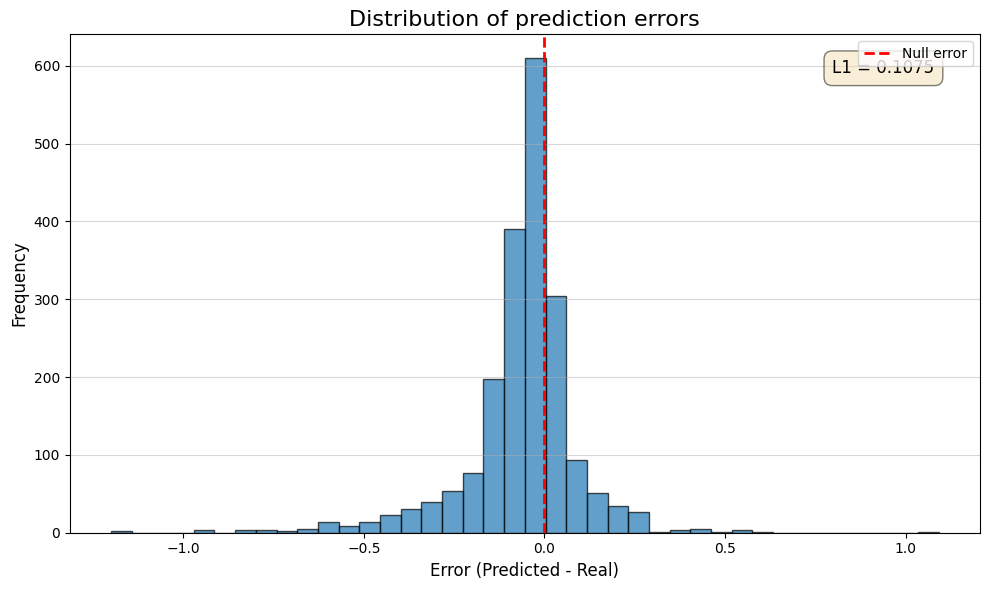

In [32]:
if os.path.exists('./predict/predict1'):
    shutil.rmtree('./predict/predict1')
    shutil.rmtree('./predict')
os.mkdir('./predict')
os.mkdir('./predict/predict1')
os.system('cp model/model_9999/model.pkl temp_files/')
os.system('cd temp_files; cp normal_para.txt normal_para_predict.txt')
os.system('cp temp_files/* ./predict/predict1')

predict_model('./predict/predict1/predictset_with_scaled_normalized.txt',nfeatures)

result_conn() 
RMSE_calu()

result_conn2() 
RMSE_calu2()

generate_plots()

## Paper comparison error

<p align="center">
  <img src="./img/PGB_VO2.png" alt="Neural network" width="400"/>
</p>

Error RMSE: 0.16

Error L1: 0.09

Error MAPE: 0.03

Error R2: 0.989

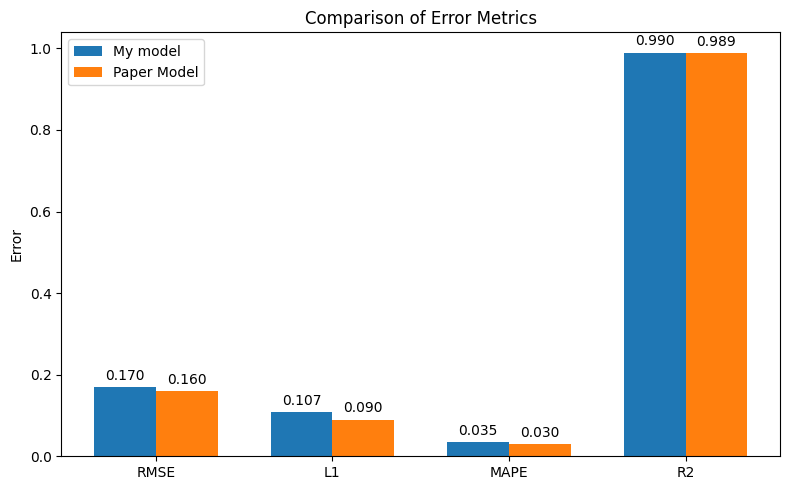

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'L1', 'MAPE', 'R2']

my_model = [0.1704340395150275, 0.10749929869999997, 0.034664627322155445, 0.9898880158227249]

# Paper model errors
paper_model = [0.16, 0.09, 0.03, 0.989]

x = np.arange(len(metrics))  # label locations
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(8,5))

bars1 = ax.bar(x - width/2, my_model, width, label='My model')
bars2 = ax.bar(x + width/2, paper_model, width, label='Paper Model')

# Add text labels above bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0,3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

ax.set_ylabel('Error')
ax.set_title('Comparison of Error Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.tight_layout()
plt.show()


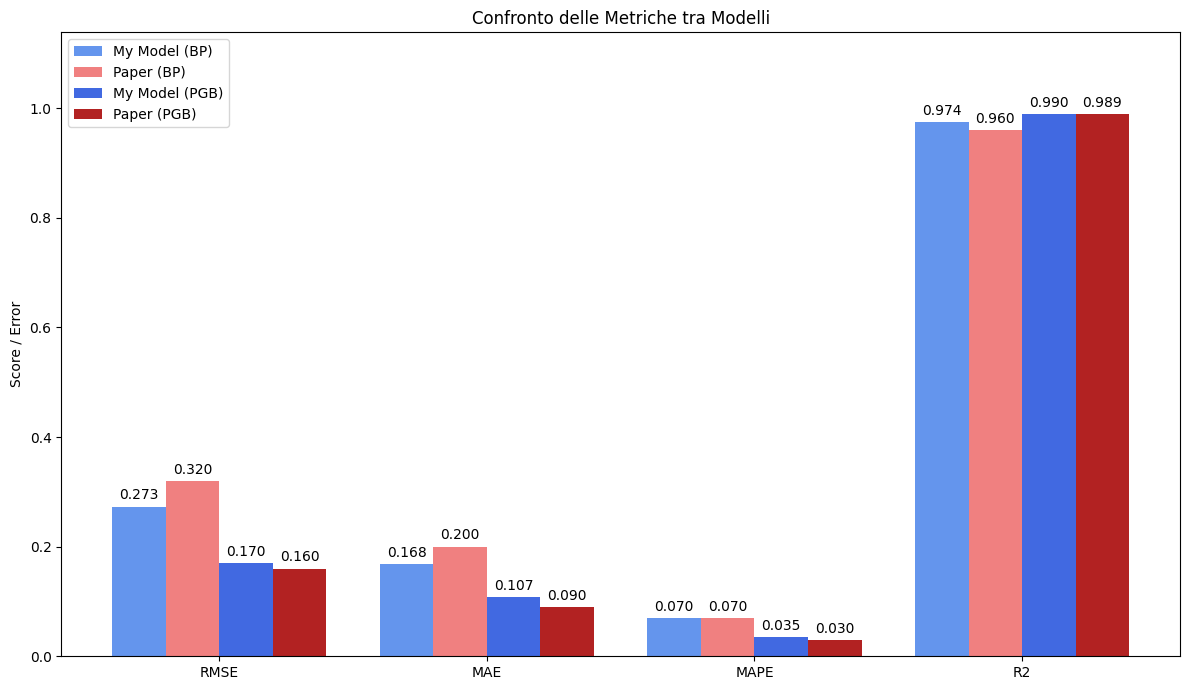

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics
metrics = ['RMSE', 'MAE', 'MAPE', 'R2']

my_model_bp = [0.27315175929998503, 0.1682789813, 0.06987143775762221, 0.9740264261659003]
my_model_pgb = [0.1704340395150275, 0.10749929869999997, 0.034664627322155445, 0.9898880158227249]

paper_bp = [0.32, 0.20, 0.07, 0.96]
paper_pgb = [0.16, 0.09, 0.03, 0.989]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 7))

bars1 = ax.bar(x - 1.5*width, my_model_bp, width, label='My Model (BP)', color='cornflowerblue')
bars2 = ax.bar(x - 0.5*width, paper_bp,    width, label='Paper (BP)',    color='lightcoral')
bars3 = ax.bar(x + 0.5*width, my_model_pgb,  width, label='My Model (PGB)',  color='royalblue')
bars4 = ax.bar(x + 1.5*width, paper_pgb,   width, label='Paper (PGB)',   color='firebrick')

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    rotation=0)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)
autolabel(bars4)

ax.set_ylabel('Score / Error')
ax.set_title('Confronto delle Metriche tra Modelli')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, max(my_model_bp + my_model_pgb + paper_bp + paper_pgb) * 1.15)
ax.legend()

fig.tight_layout()
plt.show()

## Numerical Simulation with Pyscf
Here we perform a numerical simulation using the `pyscf` library to compute the energy of a crystal structure. This is done to validate the performance of the neural network model.
We will focus on the Si crystal structure.

Reading structure from: ./data/VO2/raw_data/test/structure100000333227.xsf


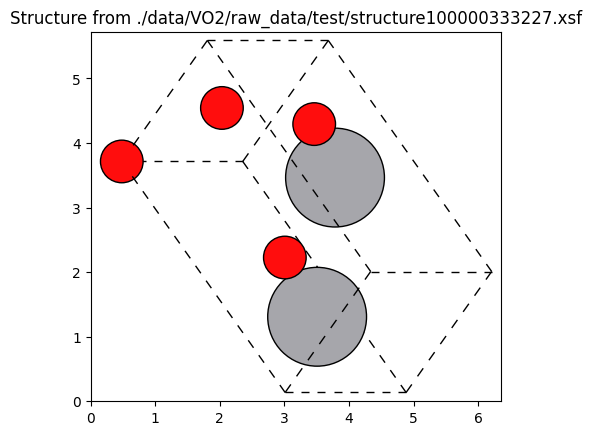

NGLWidget()

In [33]:
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview as nv


# Randomly take a .xsf from the test dataset
file_to_read = './data/VO2/raw_data/test'
file_to_read = os.path.join(file_to_read, random.choice(os.listdir(file_to_read)))
print(f"Reading structure from: {file_to_read}")
ase_atom = ase.io.read(file_to_read)

fig, ax = plt.subplots()
plot_atoms(ase_atom, ax, radii=0.5, rotation=('45x,45y,0z'))
plt.title(f"Structure from {file_to_read}")
plt.show()


# Create an interactive view from the ase object
view = nv.show_ase(ase_atom)
view.add_unitcell()
view


## Periodic Boundary Conditions (PBC)

In quantum chemistry and condensed matter physics, periodic boundary conditions are used to model infinite crystalline solids. The periodicity of the potential and electronic density in such systems reflects the translational symmetry of the crystal lattice. Each unit cell is repeated in all directions to mimic the behavior of a bulk material.

## Density Functional Theory (DFT)

DFT is a widely used method for computing the electronic structure of many-body systems. It reformulates the many-electron problem in terms of the electron density, rather than the many-body wavefunction.

## Density Fitting

To accelerate the calculation of two-electron integrals, especially in periodic systems, density fitting techniques are employed. These approximate the electron repulsion integrals using an auxiliary basis, such as a plane-wave basis, and reduce the computational scaling.
DFT calculations are carried out iteratively through a self-consistent field procedure. At each step, the electron density is updated based on the solution of the Kohn-Sham equations, and the process continues until convergence is achieved. The result is a total energy that includes kinetic, Coulomb, exchange-correlation, and pseudopotential contributions.

--- Starting K-Point Convergence Test ---

Calculating for k-mesh = [2, 2, 2]...
  -> Total Energy: -206.129722 eV
  -> Time: 65.30 seconds

Calculating for k-mesh = [4, 4, 4]...
  -> Total Energy: -206.129722 eV
  -> Time: 67.29 seconds

Calculating for k-mesh = [6, 6, 6]...
  -> Total Energy: -206.129722 eV
  -> Time: 68.06 seconds

Calculating for k-mesh = [8, 8, 8]...
  -> Total Energy: -206.129722 eV
  -> Time: 68.59 seconds

--- Convergence Test Finished ---


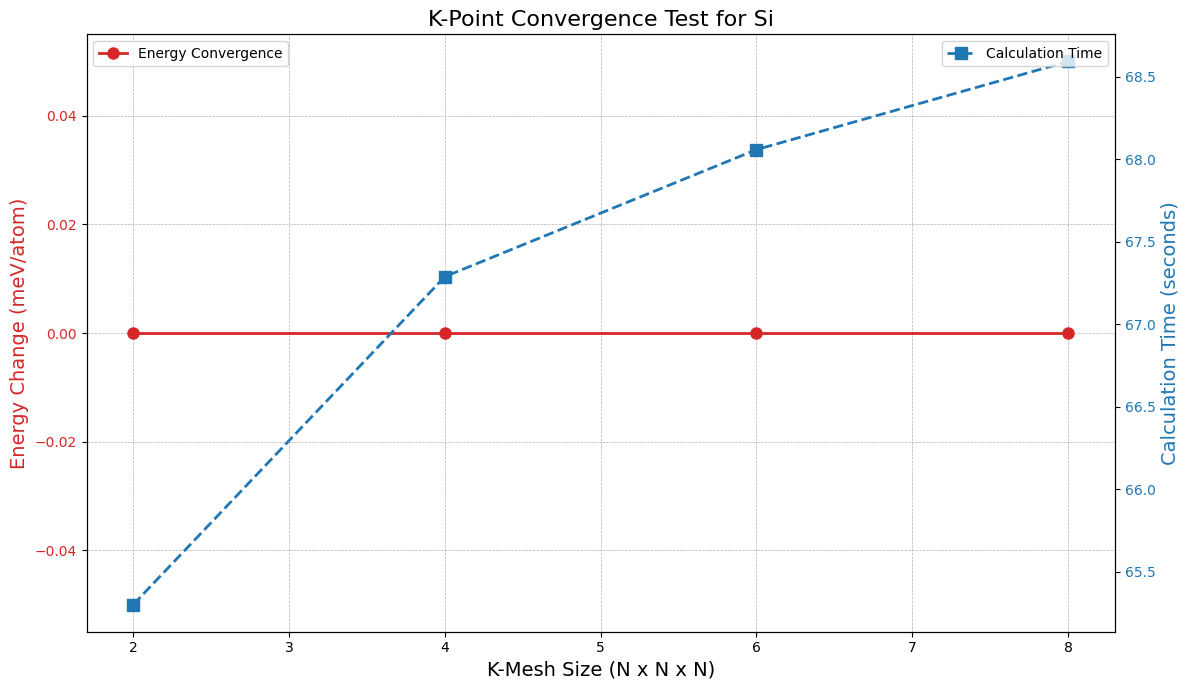


--- Results Summary ---
K-mesh 2x2x2: Energy/atom = -34.354954 eV, Delta = 0.00 meV
K-mesh 4x4x4: Energy/atom = -34.354954 eV, Delta = 0.00 meV
K-mesh 6x6x6: Energy/atom = -34.354954 eV, Delta = 0.00 meV
K-mesh 8x8x8: Energy/atom = -34.354954 eV, Delta = 0.00 meV


In [40]:
from pyscf.pbc import gto, dft, df

cell = gto.Cell()
cell.a = ase_atom.cell
cell.atom = list(zip(ase_atom.get_chemical_symbols(), ase_atom.get_positions()))
cell.basis = 'gth-szv-molopt-sr'
cell.pseudo = 'gth-pbe'
cell.unit = 'A'
cell.exp_to_discard=0.1
cell.ke_cutoff = 100
cell.build()

# --- Convergence Loop ---
k_mesh_sizes = [2, 4, 6, 8]
calculated_energies = []
calculation_times = []

print("--- Starting K-Point Convergence Test ---")

for n in k_mesh_sizes:
    now = time.time()
    kmesh = [n, n, n]
    kpts = cell.make_kpts(kmesh)
    
    print(f"\nCalculating for k-mesh = {kmesh}...")

    # Set up and run the DFT calculation
    mf = dft.KRKS(cell, kpts=kpts)
    mf.with_df = df.FFTDF(cell)
    mf.xc = 'pbe'
    mf.conv_tol = 1e-8
    mf.verbose = 0
    mf.run()
    
    # Store results
    total_energy = mf.e_tot
    calculated_energies.append(total_energy)
    
    time_taken = time.time() - now
    calculation_times.append(time_taken)
    
    print(f"  -> Total Energy: {total_energy:.6f} eV")
    print(f"  -> Time: {time_taken:.2f} seconds")

print("\n--- Convergence Test Finished ---")

# --- Process and Plot Results ---
n_atoms = len(ase_atom)
energies_per_atom = np.array(calculated_energies) / n_atoms

energy_delta_meV = (energies_per_atom - energies_per_atom[-1]) * 1000

# --- Plotting ---
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Energy vs. K-mesh size
color = 'tab:red'
ax1.set_xlabel('K-Mesh Size (N x N x N)', fontsize=14)
ax1.set_ylabel('Energy Change (meV/atom)', color=color, fontsize=14)
ax1.plot(k_mesh_sizes, energy_delta_meV, 'o-', color=color, linewidth=2, markersize=8, label='Energy Convergence')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper left')

# Plot calculation time on a second y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Calculation Time (seconds)', color=color, fontsize=14)
ax2.plot(k_mesh_sizes, calculation_times, 's--', color=color, linewidth=2, markersize=8, label='Calculation Time')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title('K-Point Convergence Test for Si', fontsize=16)
fig.tight_layout()
plt.show()

# Print final results
print("\n--- Results Summary ---")
for i, n in enumerate(k_mesh_sizes):
    print(f"K-mesh {n}x{n}x{n}: Energy/atom = {energies_per_atom[i]:.6f} eV, Delta = {energy_delta_meV[i]:.2f} meV")


Here we compare the time taken by the neural network model to predict the energy of the crystal structure with the time taken by the `pyscf` library to compute the energy using DFT.

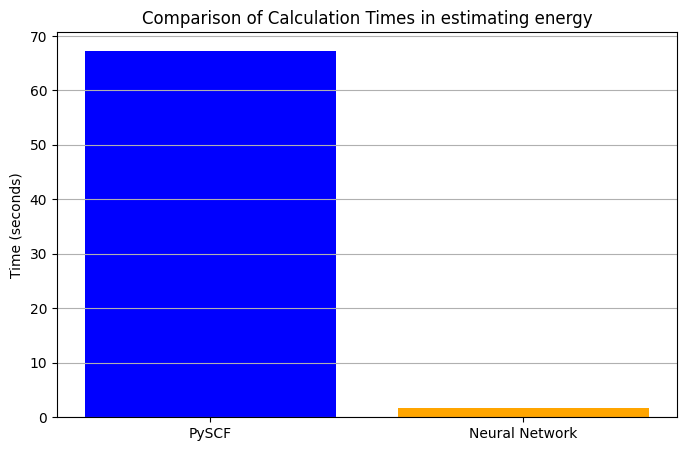

Average time for PySCF: 67.31 seconds
Time for Neural Network: 1.68 seconds


In [45]:
def plot_comparison(time_pyscf, time_nn):
    plt.figure(figsize=(8, 5))
    plt.bar(['PySCF', 'Neural Network'], [time_pyscf, time_nn], color=['blue', 'orange'])
    plt.ylabel('Time (seconds)')
    plt.title('Comparison of Calculation Times in estimating energy')
    plt.grid(axis='y')
    plt.show()

avg_time_pyscf = np.mean(calculation_times)


now = time.time()
model = NeuralNetwork(44)
model.load_state_dict(torch.load('./model/model_9999/model.pkl', map_location=torch.device('cpu')))
model.eval()
data = np.load('./predict_data/predict.npy', allow_pickle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = PredictDataset(data, device)
dataloader = DataLoader(dataset, batch_size=1)
x, flag_list, struct_name = next(iter(dataloader))
x_var = Variable(x)
output, atom_count = model(x_var, flag_list)
time_nn = time.time() - now

plot_comparison(avg_time_pyscf, time_nn)
print(f"Average time for PySCF: {avg_time_pyscf:.2f} seconds")
print(f"Time for Neural Network: {time_nn:.2f} seconds")

Reading structure from: /Users/matteobalice/Desktop/swarm_intelligence/data/VO2/raw_data/test/structure10001386619.xsf


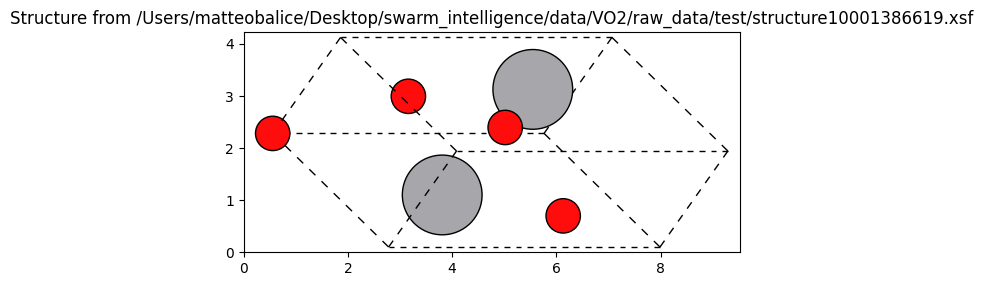

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyscf/pbc/gto/cell.py:127: UserWarning: Function cell.dumps drops attribute a because it is not JSON-serializable
  warnings.warn(msg)


  -> Total Energy: -192.662127 eV
  -> Time: 373.98 seconds
Reading structure from: /Users/matteobalice/Desktop/swarm_intelligence/data/VO2/raw_data/test/structure10002351515.xsf


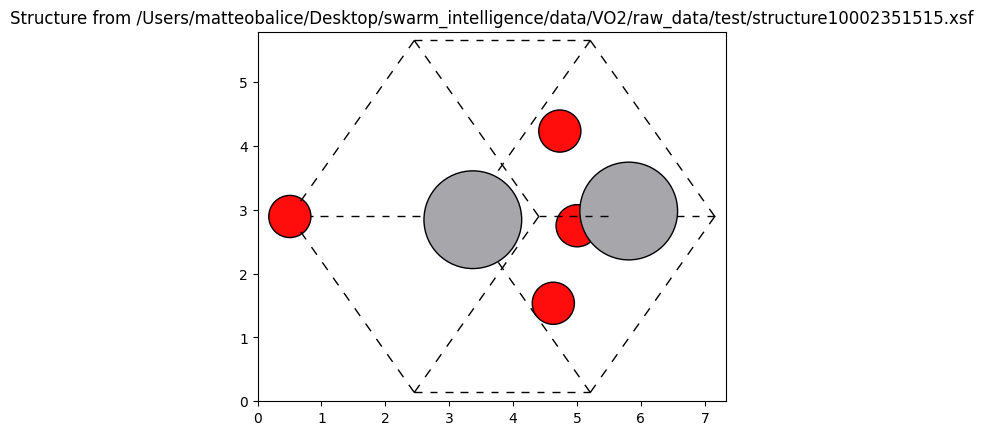

  -> Total Energy: -201.224771 eV
  -> Time: 458.19 seconds
Reading structure from: /Users/matteobalice/Desktop/swarm_intelligence/data/VO2/raw_data/test/structure100000026411.xsf


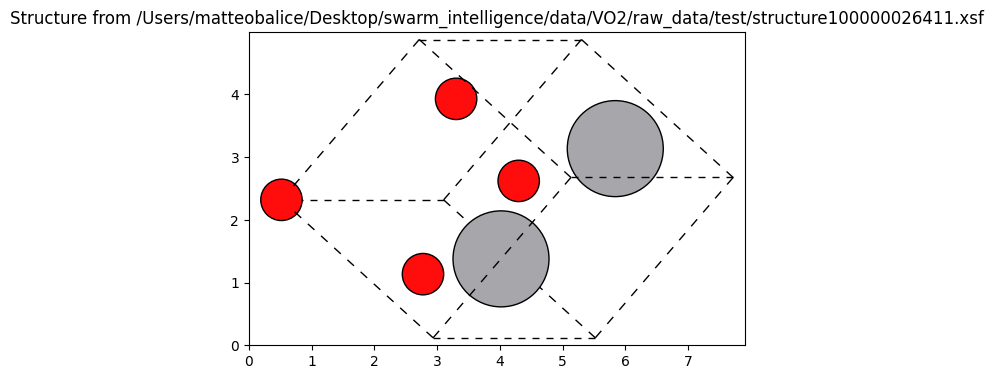

  -> Total Energy: -206.845335 eV
  -> Time: 545.17 seconds
Reading structure from: /Users/matteobalice/Desktop/swarm_intelligence/data/VO2/raw_data/test/structure100000409522.xsf


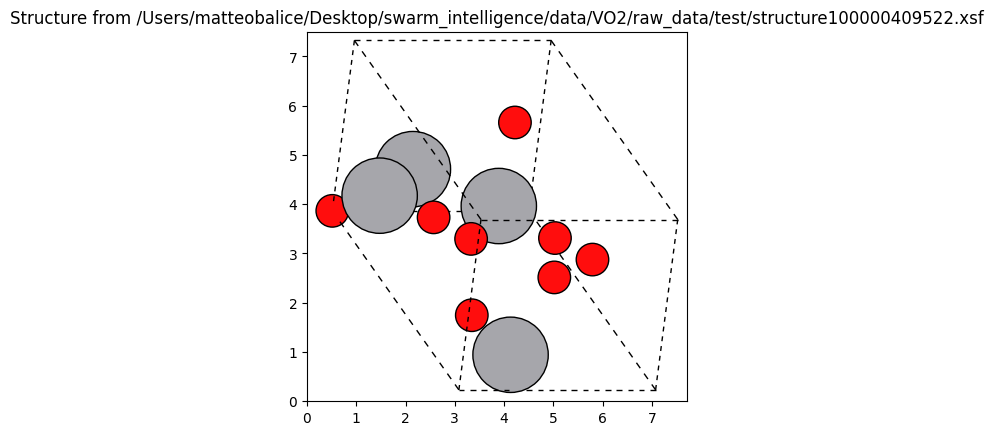

  -> Total Energy: -412.223447 eV
  -> Time: 760.58 seconds
Reading structure from: /Users/matteobalice/Desktop/swarm_intelligence/data/VO2/raw_data/test/structure100000160115.xsf


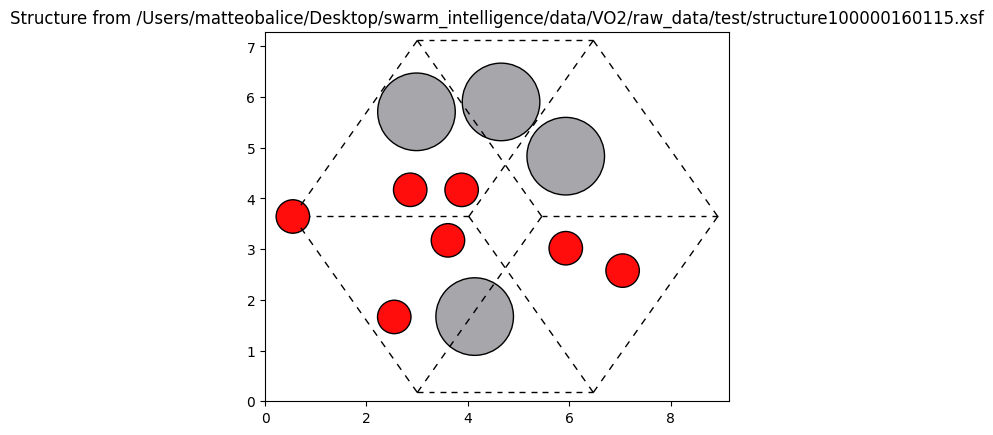

  -> Total Energy: -413.593496 eV
  -> Time: 927.25 seconds


In [49]:
import ase.io
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt
import nglview as nv
import random

file_preds = "predict/predict1/result_con.txt"
with open(file_preds, 'r') as f:
    lines = f.readlines()

# shuffle the lines randomly
random.shuffle(lines)
lines = lines[:5]


# Randomly take a .xsf from the test dataset
file_to_read1 = os.path.join(WORKPLACE, 'data/VO2/raw_data/test')
for i in range(5):
  line = lines[i].strip()
  xsf_id = line.split()[0]
  file_to_read = os.path.join(file_to_read1, f"{xsf_id}")

  print(f"Reading structure from: {file_to_read}")
  ase_atom = ase.io.read(file_to_read)

  fig, ax = plt.subplots()
  plot_atoms(ase_atom, ax, radii=0.5, rotation=('45x,45y,0z'))
  plt.title(f"Structure from {file_to_read}")
  plt.show()

  # Create an interactive view from the ase object
  view = nv.show_ase(ase_atom)
  view.add_unitcell()
  view


  cell = gto.Cell()
  cell.a = ase_atom.cell
  cell.atom = list(zip(ase_atom.get_chemical_symbols(), ase_atom.get_positions()))
  cell.basis = 'gth-szv-molopt-sr'
  cell.pseudo = 'gth-pbe'
  cell.unit = 'A'
  cell.exp_to_discard=0.1
  cell.ke_cutoff = 100
  cell.build()

  kpts = cell.make_kpts([4, 4, 4])

  # Set up and run the DFT calculation
  mf = dft.KRKS(cell, kpts=kpts)
  mf.with_df = df.FFTDF(cell)
  mf.xc = 'pbe'
  mf.conv_tol = 1e-8
  mf.verbose = 0
  mf.run()
  
  # Store results
  total_energy = mf.e_tot
  calculated_energies.append(total_energy)
  
  time_taken = time.time() - now
  calculation_times.append(time_taken)
  
  print(f"  -> Total Energy: {total_energy:.6f} eV")
  print(f"  -> Time: {time_taken:.2f} seconds")

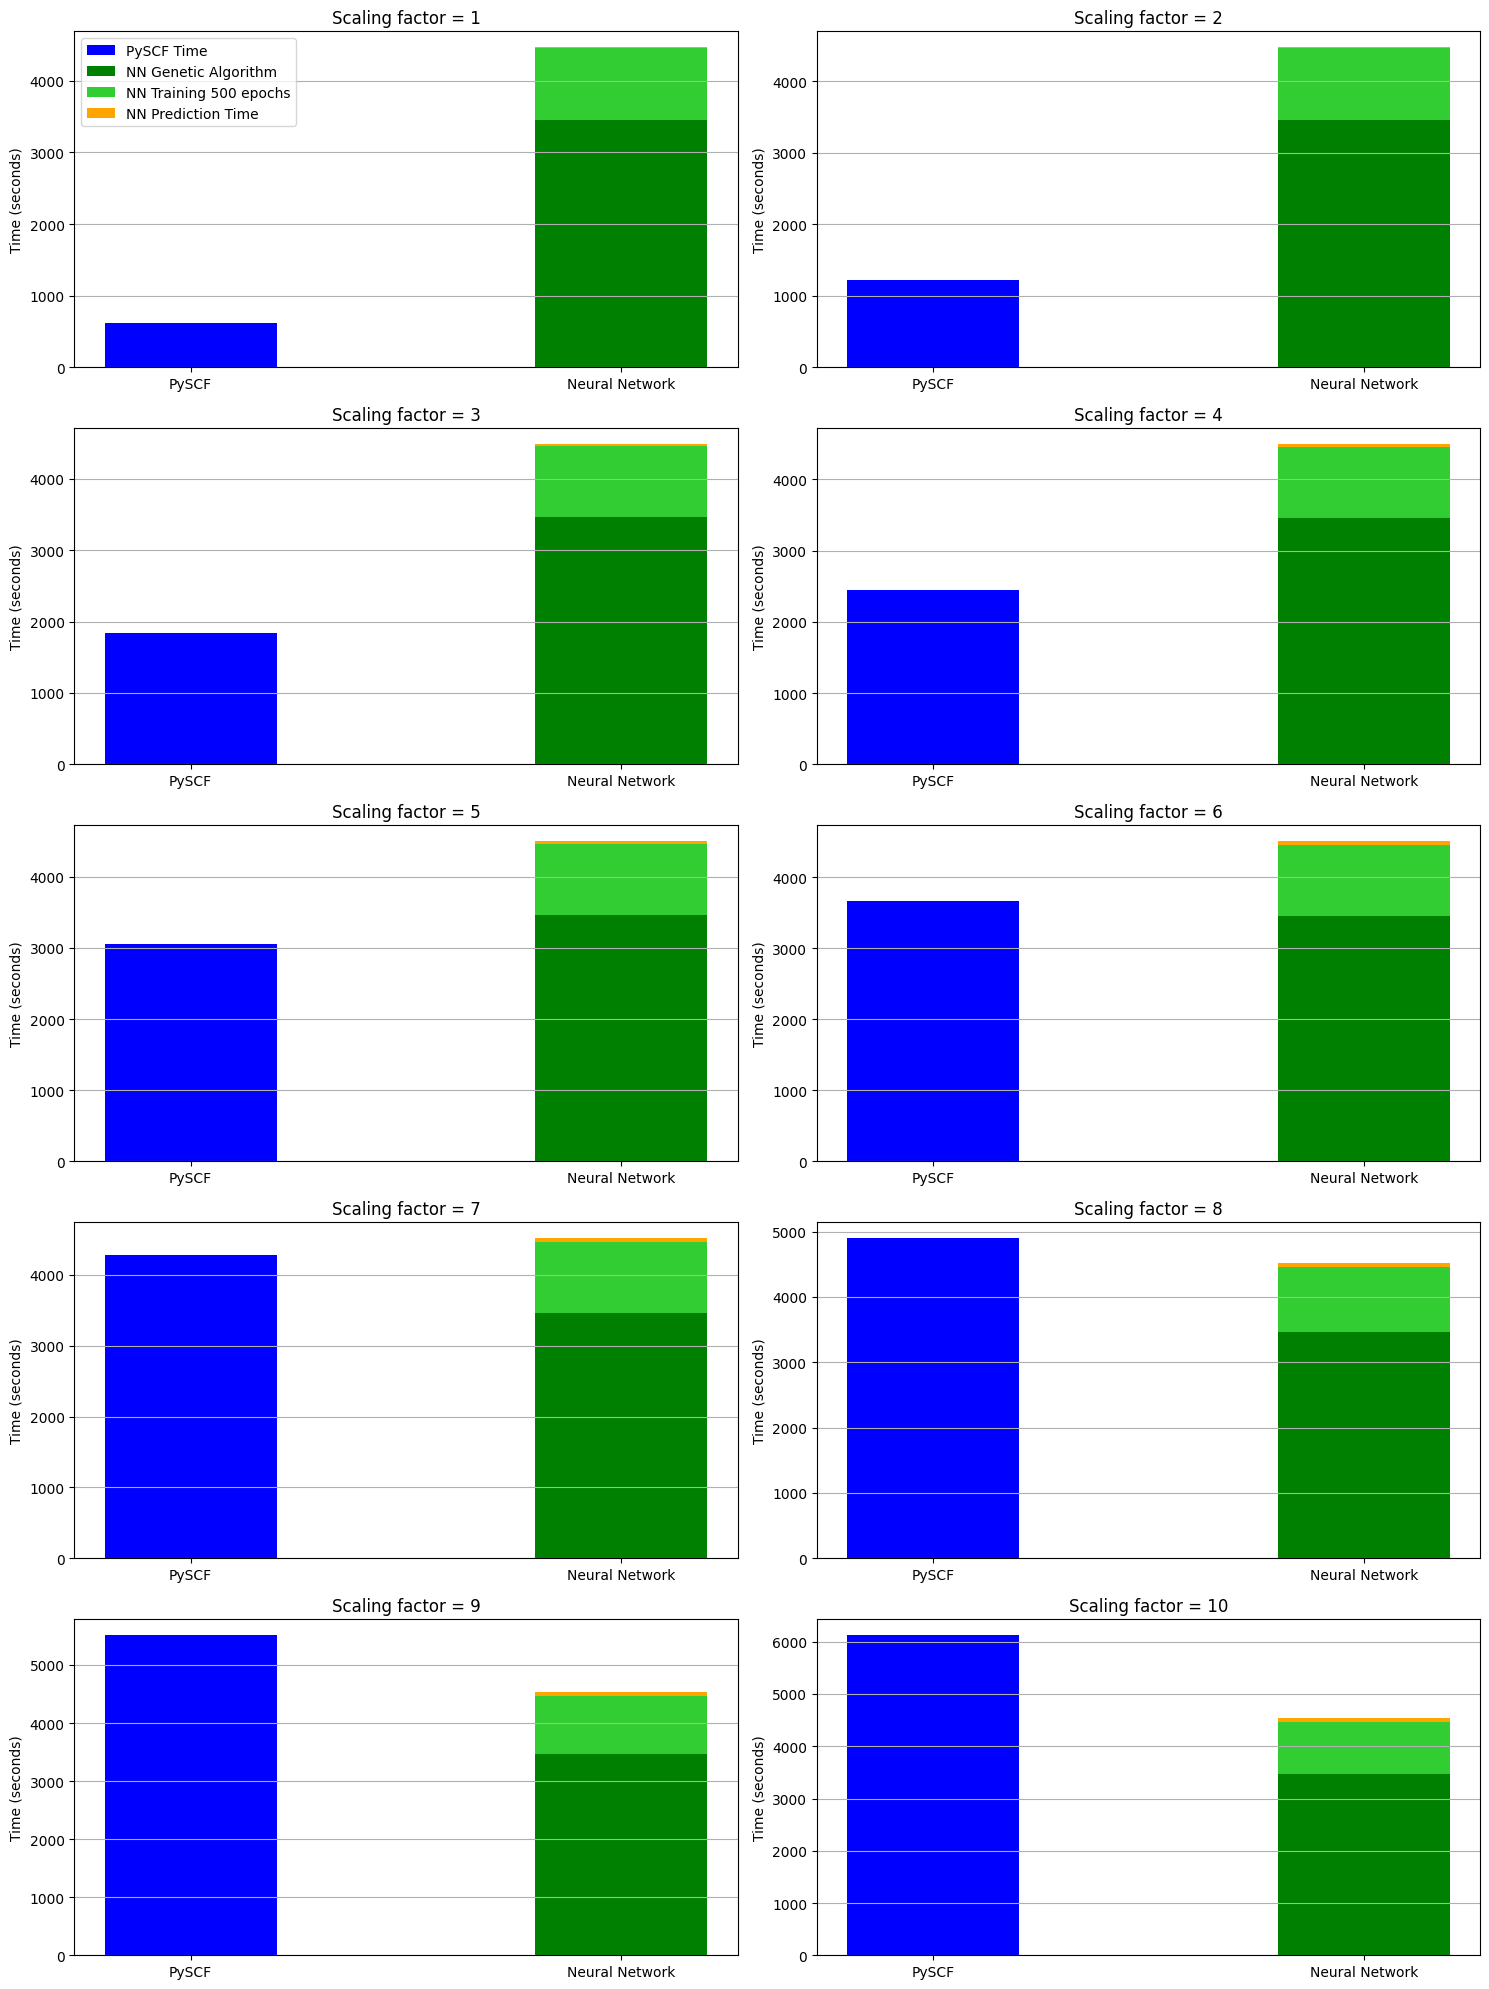

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

def plot_comparison(time_pyscf, time_nn_train_phase1, time_nn_train_phase2, time_nn_pred, factor, ax):
    labels = ['PySCF', 'Neural Network']
    x = np.arange(len(labels))
    width = 0.4

    # Scale times by factor
    pyscf_scaled = time_pyscf * factor
    train1_scaled = time_nn_train_phase1
    train2_scaled = time_nn_train_phase2
    pred_scaled = time_nn_pred * factor

    # PySCF bar
    ax.bar(x[0], pyscf_scaled, width, label='PySCF Time', color='blue')

    # NN stacked bar (train phases + prediction)
    ax.bar(x[1], train1_scaled, width, label='NN Genetic Algorithm', color='green')
    ax.bar(x[1], train2_scaled, width, bottom=train1_scaled, label='NN Training 500 epochs', color='limegreen')
    ax.bar(x[1], pred_scaled, width, bottom=train1_scaled + train2_scaled, label='NN Prediction Time', color='orange')

    ax.set_ylabel('Time (seconds)')
    ax.set_title(f'Scaling factor = {factor}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(axis='y')

    if factor == 1:
        ax.legend()

avg_time_pyscf = np.mean(calculation_times)

# Load model and measure prediction time (run once)
now = time.time()
model = NeuralNetwork(44)
model.load_state_dict(torch.load('./model/model_9999/model.pkl', map_location=torch.device('cpu')))
model.eval()
data = np.load('./predict_data/predict.npy', allow_pickle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = PredictDataset(data, device)
dataloader = DataLoader(dataset, batch_size=1)
x, flag_list, struct_name = next(iter(dataloader))
x_var = Variable(x)
output, atom_count = model(x_var, flag_list)
time_nn_pred_original = time.time() - now

# Fixed training times (taken from previous cells)
time_nn_train_phase1 = 3460
time_nn_train_phase2 = 1000

# Plot 10 graphs with 2 per row
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()

for factor in range(1, 11):
    plot_comparison(avg_time_pyscf, time_nn_train_phase1, time_nn_train_phase2, time_nn_pred_original, factor, axs[factor-1])

plt.tight_layout()
plt.show()
plt.close('all')

## Conclusion

This project successfully replicated the methodology presented in *"Swarm intelligence for new materials,"* which introduces a novel hybrid swarm intelligence algorithm designed to optimize neural networks for materials science applications. The primary goal was to develop more stable and efficient models for predicting material properties, thereby reducing dependence on computationally expensive first-principles calculations.

The implementation combined the strengths of a **Genetic Algorithm (GA)**, **Particle Swarm Optimization (PSO)**, and **Bayesian Optimization**. Specifically, PSO was employed as an advanced mutation operator within the GA framework, while Bayesian optimization was incorporated to help escape local optima.

To validate the replication, the optimized neural network was applied to predict the formation energies of several crystal structures, including **Si**, **$TiO_{2}$**, **$VO_{2}$**, and **$CaTiO_{3}$**. In addition, validation was performed through numerical simulations using the PySCF package to ensure consistency with quantum chemical calculations. The results obtained confirm the findings reported in the paper: the hybrid swarm intelligence approach (termed PGB in the original work) consistently outperformed traditional back-propagation neural networks and other combined optimization algorithms. The replicated models demonstrated both higher accuracy and improved training efficiency.